<a href="https://colab.research.google.com/github/burbox22/sayanghosh91/blob/main/raster_comparison_v1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 36.0 MB/s eta 0:00:00


                                            geometry
0  MULTIPOLYGON (((-44.02523 -22.77769, -44.02543...


<Axes: >

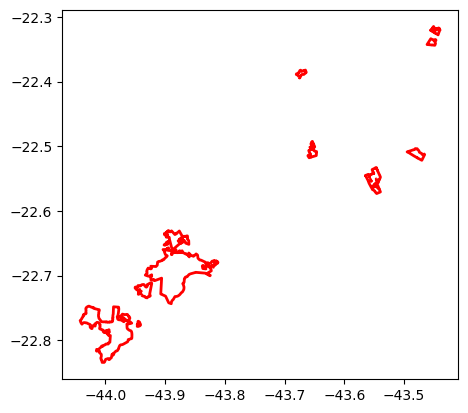

In [3]:
import geopandas as gpd

geojson_path = "/content/drive/MyDrive/Colab Notebooks/DynamicBaseline_ProjectArea_a19186df.geojson"  # Adjust the filename
gdf = gpd.read_file(geojson_path)

# Check the GeoJSON structure
print(gdf.head())

# Plot the boundary
gdf.plot(edgecolor="red", facecolor="none", linewidth=2)


In [4]:
import rasterio

# Define new raster path
new_raster_path = "/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif"  # Update with correct filename

# Open and check raster metadata
with rasterio.open(new_raster_path) as src:
    print("New Raster CRS:", src.crs)
    print("New Raster Bounds:", src.bounds)
    print("Raster Shape:", src.shape)


New Raster CRS: EPSG:4326
New Raster Bounds: BoundingBox(left=-176.218092654, bottom=-55.98521682794552, right=181.7785143810456, top=55.432827866)
Raster Shape: (12403, 39852)


In [5]:
import geopandas as gpd
import rasterio

# Load project GeoJSON
geojson_path = "/content/drive/MyDrive/Colab Notebooks/DynamicBaseline_ProjectArea_a19186df.geojson"
gdf = gpd.read_file(geojson_path)

# Function to reproject GeoJSON
def reproject_geojson(gdf, raster_path, save_path):
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs  # Get raster CRS

    if gdf.crs != raster_crs:
        print(f"Reprojecting GeoJSON to match {raster_path} CRS...")
        gdf = gdf.to_crs(raster_crs)

    gdf.to_file(save_path, driver="GeoJSON")
    return save_path

# Define raster paths
raster1_path = "/content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif"
raster2_path = "/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif"

# Save reprojected GeoJSONs
geojson1_path = reproject_geojson(gdf, raster1_path, "/content/drive/MyDrive/Colab Notebooks/v1_2_project_boundary_raster.geojson")
geojson2_path = reproject_geojson(gdf, raster2_path, "/content/drive/MyDrive/Colab Notebooks/v2_2_project_boundary_raster2.geojson")


Reprojecting GeoJSON to match /content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif CRS...


In [6]:
import geopandas as gpd
import rasterio

# Load project GeoJSON
geojson_path = "/content/drive/MyDrive/Colab Notebooks/DynamicBaseline_ProjectArea_a19186df.geojson"
gdf = gpd.read_file(geojson_path)

# Function to reproject GeoJSON
def reproject_geojson(gdf, raster_path, save_path):
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs  # Get raster CRS

    if gdf.crs != raster_crs:
        print(f"Reprojecting GeoJSON to match {raster_path} CRS...")
        gdf = gdf.to_crs(raster_crs)

    gdf.to_file(save_path, driver="GeoJSON")
    return save_path

# Define raster paths
raster1_path = "/content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif"
raster2_path = "/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif"

# Save reprojected GeoJSONs
geojson1_path = reproject_geojson(gdf, raster1_path, "/content/drive/MyDrive/Colab Notebooks/v1_2_project_boundary_raster.geojson")
geojson2_path = reproject_geojson(gdf, raster2_path, "/content/drive/MyDrive/Colab Notebooks/v2_2_project_boundary_raster2.geojson")


Reprojecting GeoJSON to match /content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif CRS...


In [13]:
import rasterio.mask
import json
import numpy as np

# Function to clip raster using its corresponding GeoJSON
def clip_raster(raster_path, geojson_path):
    with open(geojson_path) as f:
        geojson_data = json.load(f)
        geojson_geometry = [feature["geometry"] for feature in geojson_data["features"]]

    with rasterio.open(raster_path) as src:
        clipped_raster, _ = rasterio.mask.mask(src, geojson_geometry, crop=True)

    return clipped_raster

# Clip both rasters
clipped_raster1 = clip_raster(raster1_path, geojson1_path)
clipped_raster2 = clip_raster(raster2_path, geojson2_path)


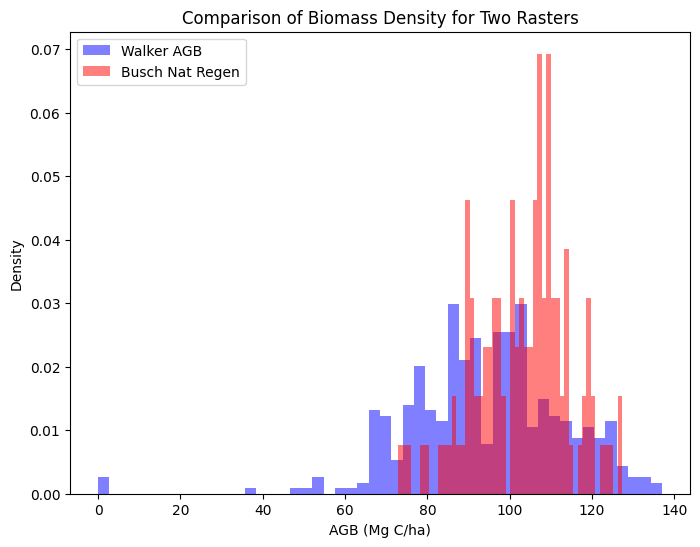

In [14]:
import matplotlib.pyplot as plt

# Convert NoData (-32768) to NaN
nodata_value = -32768
clipped_raster1 = np.where(clipped_raster1 == nodata_value, np.nan, clipped_raster1)
clipped_raster2 = np.where(clipped_raster2 == nodata_value, np.nan, clipped_raster2)

# Flatten and remove NaN values
valid_pixels1 = clipped_raster1[0].flatten()
valid_pixels2 = clipped_raster2[0].flatten()

valid_pixels1 = valid_pixels1[~np.isnan(valid_pixels1)]
valid_pixels2 = valid_pixels2[~np.isnan(valid_pixels2)]

# Plot overlapping histograms
plt.figure(figsize=(8, 6))
plt.hist(valid_pixels1, bins=50, alpha=0.5, label="Walker AGB", color="blue", density=True)
plt.hist(valid_pixels2, bins=50, alpha=0.5, label="Busch Nat Regen", color="red", density=True)
plt.xlabel("AGB (Mg C/ha)")
plt.ylabel("Density")
plt.title("Comparison of Biomass Density for Two Rasters")
plt.legend()
plt.show()


In [15]:
import geopandas as gpd
import rasterio

def reproject_geojson(geojson_path, target_crs, output_path):
    """ Reprojects a GeoJSON to a target CRS and saves it. """
    gdf = gpd.read_file(geojson_path)
    gdf = gdf.to_crs(target_crs)
    gdf.to_file(output_path, driver="GeoJSON")
    return output_path

# Load original GeoJSON
geojson_path = "/content/drive/MyDrive/Colab Notebooks/DynamicBaseline_ProjectArea_a19186df.geojson"

# Get CRS from rasters
with rasterio.open("/content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif") as src1:
    raster1_crs = src1.crs

with rasterio.open("/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif") as src2:
    raster2_crs = src2.crs

# Reproject GeoJSON to match each raster
geojson_raster1_path = "project_boundary_raster1.geojson"
geojson_raster2_path = "project_boundary_raster2.geojson"

reproject_geojson(geojson_path, raster1_crs, geojson_raster1_path)
reproject_geojson(geojson_path, raster2_crs, geojson_raster2_path)

print("✅ GeoJSON reprojected to match both rasters")


✅ GeoJSON reprojected to match both rasters


In [16]:
from rasterio.mask import mask

def clip_raster(raster_path, geojson_path, output_path):
    """ Clips a raster using a GeoJSON boundary. """
    gdf = gpd.read_file(geojson_path)
    geojson_geom = [gdf.geometry[0]]  # Ensure it's in a list

    with rasterio.open(raster_path) as src:
        clipped_data, clipped_transform = mask(src, geojson_geom, crop=True)

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": clipped_data.shape[1],
            "width": clipped_data.shape[2],
            "transform": clipped_transform
        })

        # Save clipped raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(clipped_data)

# Clip rasters using corresponding GeoJSONs
clipped_raster1_path = "clipped_raster1.tif"
clipped_raster2_path = "clipped_raster2.tif"

clip_raster("/content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif", geojson_raster1_path, clipped_raster1_path)
clip_raster("/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif", geojson_raster2_path, clipped_raster2_path)

print("✅ Rasters clipped using respective GeoJSONs")


✅ Rasters clipped using respective GeoJSONs


In [17]:
from rasterio.warp import Resampling
import numpy as np

def resample_raster(source_path, match_path, output_path):
    """ Resamples a raster to match another raster's resolution and extent. """
    with rasterio.open(source_path) as src, rasterio.open(match_path) as match_src:
        match_transform = match_src.transform
        match_width, match_height = match_src.width, match_src.height

        resampled_data = src.read(
            out_shape=(src.count, match_height, match_width),
            resampling=Resampling.nearest
        )

        out_meta = src.meta.copy()
        out_meta.update({
            "height": match_height,
            "width": match_width,
            "transform": match_transform
        })

        with rasterio.open(output_path, "w", **out_meta) as dst:
            dst.write(resampled_data)

# Check if resampling is needed
with rasterio.open(clipped_raster1_path) as src1, rasterio.open(clipped_raster2_path) as src2:
    shape1 = (src1.count, src1.height, src1.width)
    shape2 = (src2.count, src2.height, src2.width)

if shape1 != shape2:
    resampled_raster2_path = "resampled_raster2.tif"
    resample_raster(clipped_raster2_path, clipped_raster1_path, resampled_raster2_path)
    raster2_final_path = resampled_raster2_path
    print("✅ Raster 2 resampled to match Raster 1")
else:
    raster2_final_path = clipped_raster2_path
    print("✅ No resampling needed")

raster1_final_path = clipped_raster1_path


✅ Raster 2 resampled to match Raster 1


In [18]:
import pandas as pd
import numpy as np
import rasterio

def extract_pixel_values(raster1_path, raster2_path, output_csv):
    """ Extracts pixel values from Raster 1 and both bands of Raster 2, then saves to CSV. """
    with rasterio.open(raster1_path) as src1, rasterio.open(raster2_path) as src2:
        data1 = src1.read(1)  # First band of Raster 1
        data2_band1 = src2.read(1)  # Band A of Raster 2
        data2_band2 = src2.read(2)  # Band K of Raster 2

        # Convert NoData (-32768) to NaN
        nodata_value = -32768
        data1 = np.where(data1 == nodata_value, np.nan, data1)
        data2_band1 = np.where(data2_band1 == nodata_value, np.nan, data2_band1)
        data2_band2 = np.where(data2_band2 == nodata_value, np.nan, data2_band2)

        rows, cols = data1.shape
        transform = src1.transform

        # Store pixel data
        data = []
        for row in range(rows):
            for col in range(cols):
                val1 = data1[row, col]
                val2_A = data2_band1[row, col]
                val2_K = data2_band2[row, col]

                if np.isnan(val1) or np.isnan(val2_A) or np.isnan(val2_K):
                    continue

                x, y = rasterio.transform.xy(transform, row, col)
                data.append([x, y, val1, val2_A, val2_K])

    df = pd.DataFrame(data, columns=["X", "Y", "Raster1_Value", "Raster2_BandA_Value", "Raster2_BandK_Value"])
    df.to_csv(output_csv, index=False)
    print(f"✅ CSV saved: {output_csv}")

# Generate CSV
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
extract_pixel_values(raster1_final_path, raster2_final_path, csv_path)


✅ CSV saved: /content/drive/MyDrive/Colab Notebooks/raster_comparison.csv


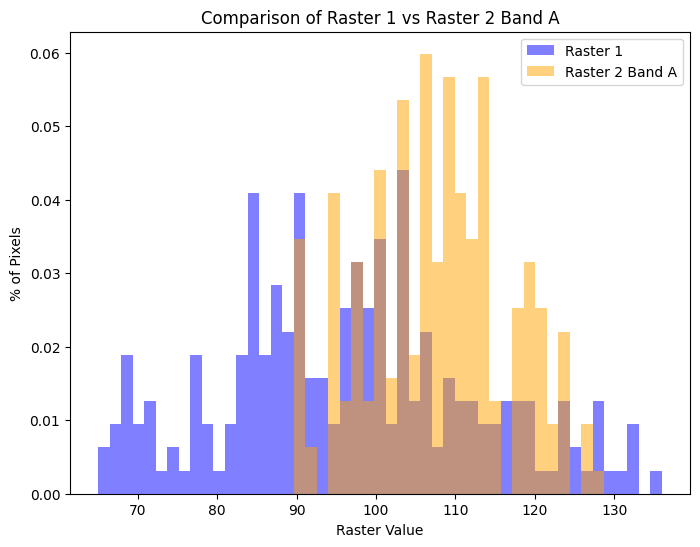

✅ Jaccard Similarity: 52.48%


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# Load the extracted pixel values from the CSV
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)

# Extract relevant columns
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# Normalize counts for % of pixels
bins = np.linspace(min(raster1_values.min(), raster2_bandA_values.min()),
                   max(raster1_values.max(), raster2_bandA_values.max()), 50)

plt.figure(figsize=(8,6))
plt.hist(raster1_values, bins, alpha=0.5, color="blue", label="Raster 1", density=True)
plt.hist(raster2_bandA_values, bins, alpha=0.5, color="orange", label="Raster 2 Band A", density=True)
plt.ylabel("% of Pixels")
plt.xlabel("Raster Value")
plt.legend()
plt.title("Comparison of Raster 1 vs Raster 2 Band A")

plt.show()

# Calculate Jaccard Similarity (converting continuous data into a binary presence/absence)
threshold = np.percentile(raster1_values, 50)  # Using median as threshold
raster1_binary = (raster1_values >= threshold).astype(int)
raster2_binary = (raster2_bandA_values >= threshold).astype(int)

# Jaccard index
jaccard_index = jaccard_score(raster1_binary, raster2_binary)
print(f"✅ Jaccard Similarity: {jaccard_index:.2%}")


Enter the maximum stand age (years): 40


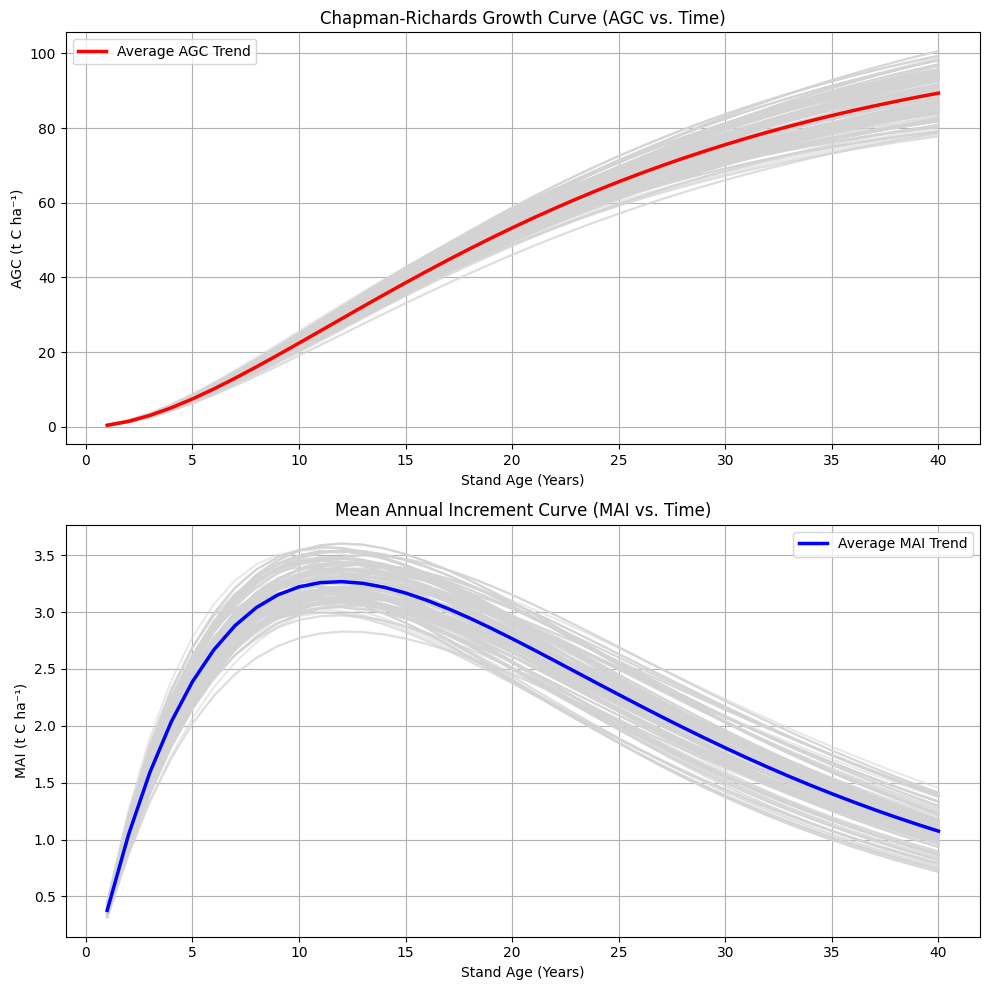

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the raster comparison CSV
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)

# Ask the user for the maximum stand age (t)
t_max = int(input("Enter the maximum stand age (years): "))

# Generate time values from 1 to t_max
t_values = np.arange(1, t_max + 1)

# Store all AGC and MAI curves
agc_curves = []
mai_curves = []

# Create figures for AGC and MAI plots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Compute AGC and MAI for each (X, Y) point
for index, row in df.iterrows():
    A = row["Raster2_BandA_Value"]
    k = row["Raster2_BandK_Value"]

    # Compute AGC using Chapman-Richards equation
    AGC = A * (1 - np.exp(-k * t_values))**2
    agc_curves.append(AGC)

    # Compute MAI as the difference in AGC between consecutive years
    MAI = np.diff(AGC, prepend=0)  # Prepend 0 to align sizes
    mai_curves.append(MAI)

    # Plot individual AGC and MAI curves
    axes[0].plot(t_values, AGC, color='lightgray', alpha=0.5)
    axes[1].plot(t_values, MAI, color='lightgray', alpha=0.5)

# Compute the average AGC and MAI trends
average_agc = np.mean(agc_curves, axis=0)
average_mai = np.mean(mai_curves, axis=0)

# Overlay the average trends
axes[0].plot(t_values, average_agc, color='red', linewidth=2.5, label="Average AGC Trend")
axes[1].plot(t_values, average_mai, color='blue', linewidth=2.5, label="Average MAI Trend")

# Set titles, labels, and legends
axes[0].set_title("Chapman-Richards Growth Curve (AGC vs. Time)")
axes[0].set_xlabel("Stand Age (Years)")
axes[0].set_ylabel("AGC (t C ha⁻¹)")
axes[0].legend()
axes[0].grid(True)

axes[1].set_title("Mean Annual Increment Curve (MAI vs. Time)")
axes[1].set_xlabel("Stand Age (Years)")
axes[1].set_ylabel("MAI (t C ha⁻¹)")
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()



In [22]:
while True:
    try:
        ref_year = int(input(f"Enter a reference year (1 to {t_max}): "))  # Ensure integer input

        if ref_year < 1 or ref_year > t_max:
            print(f"❌ Error: Reference year must be between 1 and {t_max}. Try again.")
        else:
            break  # Valid input, exit loop

    except ValueError:
        print("❌ Invalid input! Please enter a valid integer.")

# Ask user for their modeled AGC for the chosen reference year
while True:
    try:
        user_agc = float(input(f"Enter your modeled AGC (t C ha⁻¹) for year {ref_year}: "))
        break  # Valid input, exit loop
    except ValueError:
        print("❌ Invalid input! Please enter a valid number.")

# Extract AGC values for all (X, Y) at the reference year
ref_year_index = ref_year - 1  # Since index starts at 0

try:
    agc_at_ref_year = [curve[ref_year_index] for curve in agc_curves]

    # Calculate quartiles and median
    p25 = np.percentile(agc_at_ref_year, 25)
    p75 = np.percentile(agc_at_ref_year, 75)
    median_agc = np.median(agc_at_ref_year)

    # Check if the user AGC falls within [P25, P75]
    if p25 <= user_agc <= p75:
        status = "✅ Yes, your AGC is within the quartile range!"
    else:
        status = "❌ No, your AGC is outside the quartile range!"

    # Calculate percentage difference from the median
    percent_diff = ((user_agc - median_agc) / median_agc) * 100

    # Display results
    print("\n📊 **AGC Reference Year Analysis** 📊")
    print(f"🔹 Reference Year: {ref_year}")
    print(f"🔹 Your Modeled AGC: {user_agc:.2f} t C ha⁻¹")
    print(f"🔹 Quartile Range (P25 - P75): {p25:.2f} to {p75:.2f} t C ha⁻¹")
    print(f"🔹 Median AGC: {median_agc:.2f} t C ha⁻¹")
    print(f"🔹 {status}")
    print(f"🔹 Your AGC is {percent_diff:.2f}% {'higher' if percent_diff > 0 else 'lower'} than the median.")

except IndexError:
    print(f"❌ Error: Unable to fetch AGC data for year {ref_year}. Check dataset size.")


Enter a reference year (1 to 40): 40
Enter your modeled AGC (t C ha⁻¹) for year 40: 78

📊 **AGC Reference Year Analysis** 📊
🔹 Reference Year: 40
🔹 Your Modeled AGC: 78.00 t C ha⁻¹
🔹 Quartile Range (P25 - P75): 85.21 to 93.98 t C ha⁻¹
🔹 Median AGC: 89.68 t C ha⁻¹
🔹 ❌ No, your AGC is outside the quartile range!
🔹 Your AGC is -13.02% lower than the median.


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve.csv


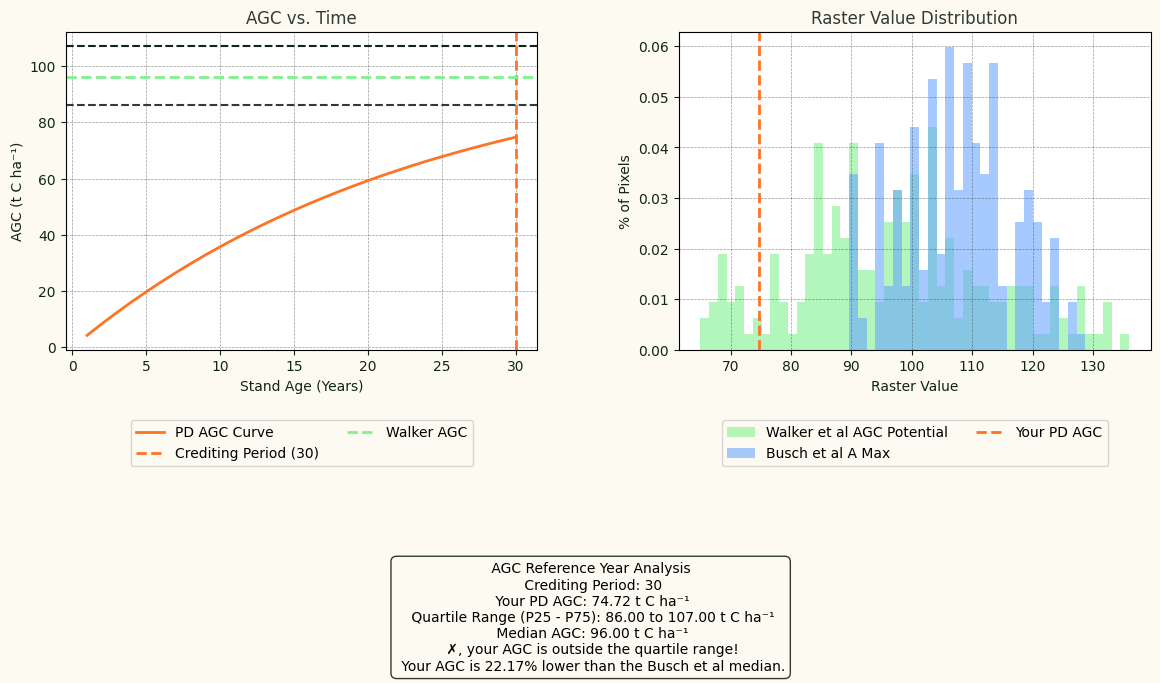

In [24]:
from google.colab import files
uploaded = files.upload()

# Get the uploaded file name
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)


# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# Compute quartiles and median for Raster1_Value
raster1_values = df["Raster1_Value"].dropna().values
p25 = np.percentile(raster1_values, 25)
p75 = np.percentile(raster1_values, 75)
median_agc = np.median(raster1_values)

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze color for PD AGC Curve
color_lidar_green = "#81F18E"
color_eggshell = "#FDFBF1"
color_pine = "#0E2517"
color_charcoal = "#303B36"
color_white = "#FFFFFF"
color_flax = "#6BA6FF"
color_pearl = "#E0E7E7"
color_hibiscus = "#EE88FF"

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left) ----
ax1 = axes[0]

# Overlay PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2, label="PD AGC Curve")

# Vertical Line at Crediting Period
ax1.axvline(crediting_period, color=color_pd_agc, linestyle="dashed", linewidth=2, label=f"Crediting Period ({crediting_period})")

# Walker Quartiles
ax1.axhline(p25, color=color_charcoal, linestyle="dashed", linewidth=1.5)
ax1.axhline(p75, color=color_pine, linestyle="dashed", linewidth=1.5)
ax1.axhline(median_agc, color=color_lidar_green, linestyle="dashed", linewidth=2, label="Walker AGC")

ax1.set_xlabel("Stand Age (Years)", color=color_pine)
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine)
ax1.set_title("AGC vs. Time", color=color_charcoal)
ax1.tick_params(colors=color_pine)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=True, facecolor=color_eggshell)

ax1.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)

# ---- 2️⃣ Raster Histogram (Right) ----
ax2 = axes[1]

# Walker and Busch Histograms
bins = np.linspace(min(raster1_values.min(), df["Raster2_BandA_Value"].dropna().min()),
                   max(raster1_values.max(), df["Raster2_BandA_Value"].dropna().max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al AGC Potential", density=True)
ax2.hist(df["Raster2_BandA_Value"].dropna(), bins, alpha=0.6, color=color_flax, label="Busch et al A Max", density=True)

# User PD AGC Vertical Line
ax2.axvline(user_agc, color=color_pd_agc, linestyle="dashed", linewidth=2, label="Your PD AGC")

ax2.set_xlabel("Raster Value", color=color_pine)
ax2.set_ylabel("% of Pixels", color=color_pine)
ax2.set_title("Raster Value Distribution", color=color_charcoal)
ax2.tick_params(colors=color_pine)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=True, facecolor=color_eggshell)

ax2.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)

# ---- 📊 Overlay Analysis Text ----
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Crediting Period: {crediting_period}\n"
    f" Your PD AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {p25:.2f} to {p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {median_agc:.2f} t C ha⁻¹\n"
    f" {'✓' if p25 <= user_agc <= p75 else '✗'}, your AGC is "
    f"{'within' if p25 <= user_agc <= p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(((user_agc - median_agc) / median_agc) * 100):.2f}% "
    f"{'higher' if user_agc > median_agc else 'lower'} than the Busch et al median."
)

plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center", fontfamily="DejaVu Sans",
            bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()


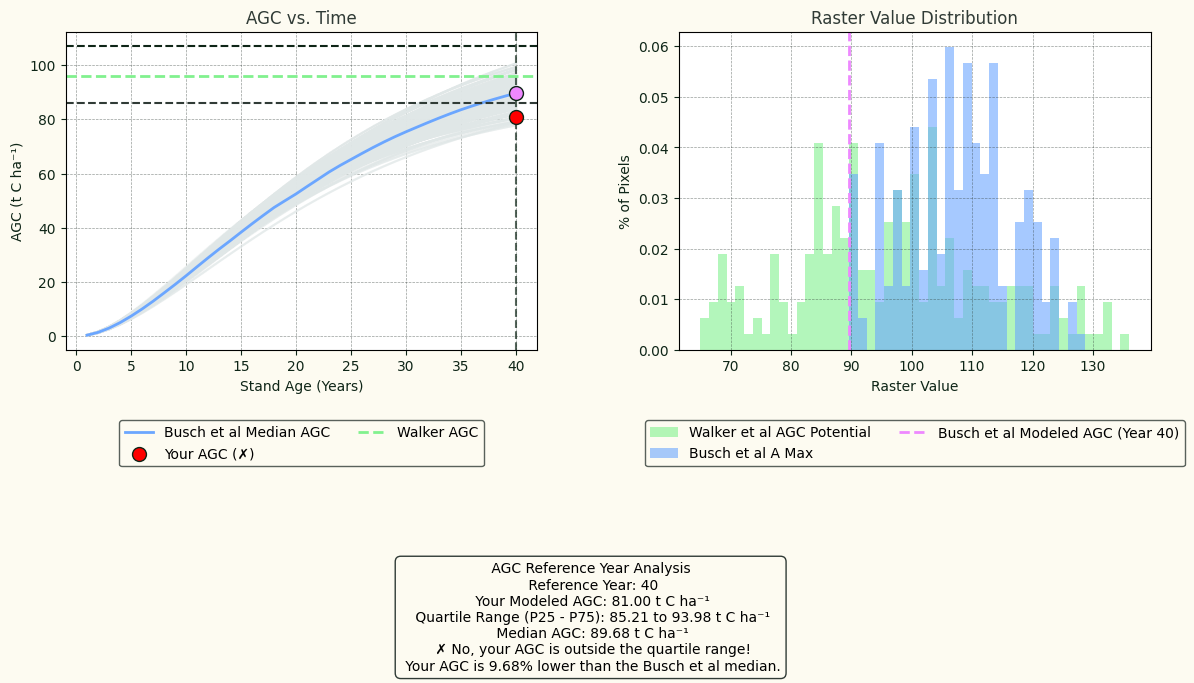

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# Load the raster comparison CSV
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)

# Extract values
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# Compute quartiles and median for Raster1_Value
raster1_p25 = np.percentile(raster1_values, 25)
raster1_p75 = np.percentile(raster1_values, 75)
raster1_median = np.median(raster1_values)

# Histogram Bins
bins = np.linspace(min(raster1_values.min(), raster2_bandA_values.min()),
                   max(raster1_values.max(), raster2_bandA_values.max()), 50)

# Time range
years = np.arange(1, t_max + 1)

# ---- Define Colors ----
color_lidar_green = "#81F18E"  # Walker et al AGC Potential
color_eggshell = "#FDFBF1"  # Background
color_pine = "#0E2517"  # Axis and text
color_charcoal = "#303B36"  # Grid lines
color_white = "#FFFFFF"  # Text Box
color_flax = "#6BA6FF"  # Busch et al A Max
color_pearl = "#E0E7E7"  # AGC curves from Busch et al
color_hibiscus = "#EE88FF"  # Vertical line for Busch et al modeled AGC

# ---- Create Figure with Two Side-by-Side Plots ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left Side) ----
ax1 = axes[0]

# AGC Curves from Busch et al (Pearl Color)
for curve in agc_curves:
    ax1.plot(years, curve, color=color_pearl, alpha=0.5)

# Busch et al Median AGC (Flax Color)
median_agc_curve = np.median(agc_curves, axis=0)
ax1.plot(years, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al Median AGC")

# Final AGC Point as Hibiscus Marker
ax1.scatter(years[-1], median_agc_curve[-1], color=color_hibiscus, s=100, edgecolor=color_pine, zorder=3)

# User Input AGC Marker
marker_style = "✓" if p25 <= user_agc <= p75 else "✗"
marker_color = color_lidar_green if p25 <= user_agc <= p75 else "red"
ax1.scatter(ref_year, user_agc, color=marker_color, s=100, edgecolor=color_pine, label=f"Your AGC ({marker_style})", zorder=3)

ax1.axvline(ref_year, color=color_pine, linestyle="dashed", alpha=0.7)

# **Walker Lines: P25, P75, and Median from Raster1 (Matching Walker Color)**
ax1.axhline(raster1_p25, color=color_charcoal, linestyle='dashed', linewidth=1.5)
ax1.axhline(raster1_p75, color=color_pine, linestyle='dashed', linewidth=1.5)
ax1.axhline(raster1_median, color=color_lidar_green, linestyle='dashed', linewidth=2, label="Walker AGC")

ax1.set_xlabel("Stand Age (Years)", color=color_pine)
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine)
ax1.set_title("AGC vs. Time", color=color_charcoal)
ax1.tick_params(colors=color_pine)

ax1.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)

# Move legend below the chart
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 2️⃣ Raster Histogram (Right Side) ----
ax2 = axes[1]
ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al AGC Potential", density=True)
ax2.hist(raster2_bandA_values, bins, alpha=0.6, color=color_flax, label="Busch et al A Max", density=True)

# **Get Busch et al Median AGC at End of Crediting Period and Add Vertical Line**
final_year = years[-1]  # Last year in the dataset
busch_median_agc_end = median_agc_curve[-1]  # Last value in the median curve

ax2.axvline(busch_median_agc_end, color=color_hibiscus, linestyle='dashed', linewidth=2,
            label=f"Busch et al Modeled AGC (Year {final_year})")

ax2.set_xlabel("Raster Value", color=color_pine)
ax2.set_ylabel("% of Pixels", color=color_pine)
ax2.set_title("Raster Value Distribution", color=color_charcoal)
ax2.tick_params(colors=color_pine)

ax2.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)

# Move legend below the chart
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 📊 Overlay Analysis Text Below (EXACT FORMAT AS REQUESTED) ----
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Reference Year: {ref_year}\n"
    f" Your Modeled AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {p25:.2f} to {p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {median_agc:.2f} t C ha⁻¹\n"
    f" {marker_style} {'Yes' if p25 <= user_agc <= p75 else 'No'}, your AGC is "
    f"{'within' if p25 <= user_agc <= p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(percent_diff):.2f}% {'higher' if percent_diff > 0 else 'lower'} than the Busch et al median."
)

plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center", fontfamily="DejaVu Sans",
            bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)  # Adjust layout for clear visualization
plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (2).csv


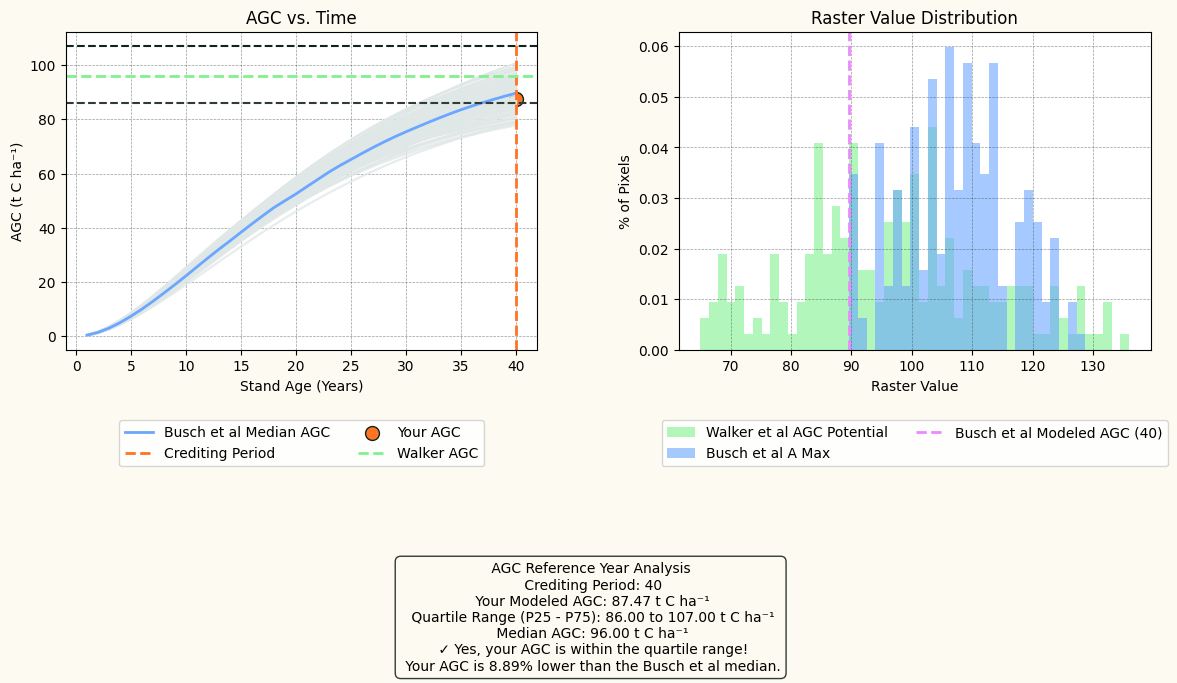

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload User CSV (Years, AGC) ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)
df_user.columns = ["Years", "AGC"]

# Extract Credit Period and User AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# Load Raster Comparison CSV
raster_csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(raster_csv_path)

# Extract values
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# Compute quartiles and median for Walker et al (Raster1)
p25, p75 = np.percentile(raster1_values, [25, 75])
median_agc = np.median(raster1_values)

# Generate AGC Curves using Chapman-Richards
years = np.arange(1, crediting_period + 1)
agc_curves = []
for index, row in df.iterrows():
    A, k = row["Raster2_BandA_Value"], row["Raster2_BandK_Value"]
    agc_curves.append(A * (1 - np.exp(-k * years))**2)

# Compute Median AGC Curve for Busch et al
median_agc_curve = np.median(agc_curves, axis=0)

# ---- Define Colors ----
color_lidar_green = "#81F18E"
color_eggshell = "#FDFBF1"
color_pine = "#0E2517"
color_charcoal = "#303B36"
color_white = "#FFFFFF"
color_flax = "#6BA6FF"
color_pearl = "#E0E7E7"
color_hibiscus = "#EE88FF"
color_blaze = "#FF7324"

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve ----
ax1 = axes[0]
for curve in agc_curves:
    ax1.plot(years, curve, color=color_pearl, alpha=0.5)
ax1.plot(years, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al Median AGC")
ax1.axvline(crediting_period, color=color_blaze, linestyle="dashed", linewidth=2, label="Crediting Period")
ax1.scatter(crediting_period, user_agc, color=color_blaze, s=100, edgecolor=color_pine, label=f"Your AGC")
ax1.axhline(p25, color=color_charcoal, linestyle='dashed', linewidth=1.5)
ax1.axhline(p75, color=color_pine, linestyle='dashed', linewidth=1.5)
ax1.axhline(median_agc, color=color_lidar_green, linestyle='dashed', linewidth=2, label="Walker AGC")
ax1.set_xlabel("Stand Age (Years)")
ax1.set_ylabel("AGC (t C ha⁻¹)")
ax1.set_title("AGC vs. Time")
ax1.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2)

# ---- 2️⃣ Raster Histogram ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), raster2_bandA_values.min()), max(raster1_values.max(), raster2_bandA_values.max()), 50)
ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al AGC Potential", density=True)
ax2.hist(raster2_bandA_values, bins, alpha=0.6, color=color_flax, label="Busch et al A Max", density=True)
ax2.axvline(median_agc_curve[-1], color=color_hibiscus, linestyle='dashed', linewidth=2, label=f"Busch et al Modeled AGC ({crediting_period})")
ax2.set_xlabel("Raster Value")
ax2.set_ylabel("% of Pixels")
ax2.set_title("Raster Value Distribution")
ax2.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2)

# ---- 📊 Overlay Analysis ----
percent_diff = ((user_agc - median_agc) / median_agc) * 100
marker_style = "✓" if p25 <= user_agc <= p75 else "✗"
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Crediting Period: {crediting_period}\n"
    f" Your Modeled AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {p25:.2f} to {p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {median_agc:.2f} t C ha⁻¹\n"
    f" {marker_style} {'Yes' if p25 <= user_agc <= p75 else 'No'}, your AGC is "
    f"{'within' if p25 <= user_agc <= p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(percent_diff):.2f}% {'higher' if percent_diff > 0 else 'lower'} than the Busch et al median."
)
plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center", fontfamily="DejaVu Sans",
            bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()


NameError: name 'pd_agc_curve' is not defined

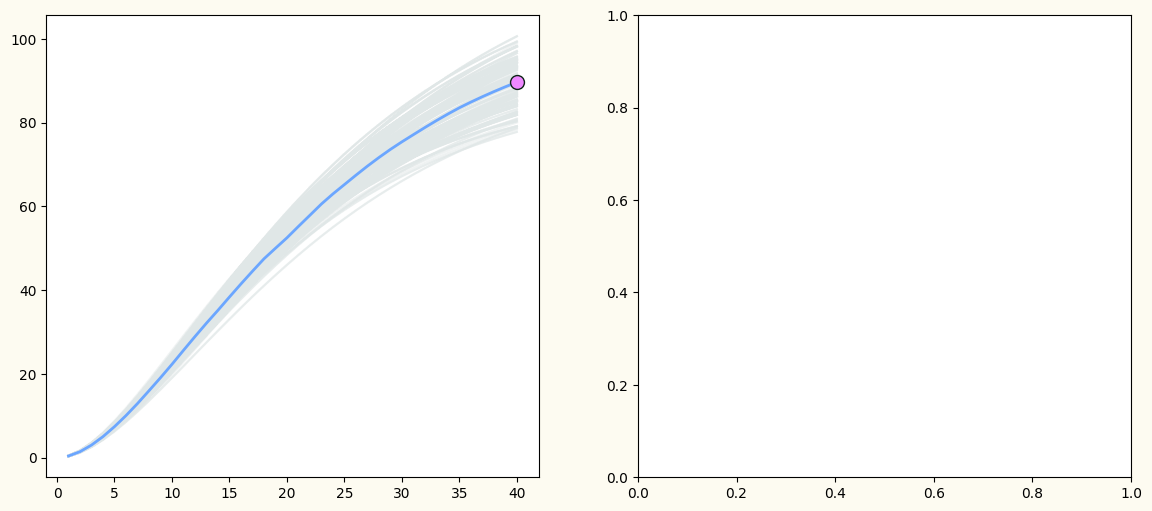

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the raster comparison CSV
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)

# Extract values
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# Compute quartiles and median for Raster1_Value
raster1_p25 = np.percentile(raster1_values, 25)
raster1_p75 = np.percentile(raster1_values, 75)
raster1_median = np.median(raster1_values)

# Histogram Bins
bins = np.linspace(min(raster1_values.min(), raster2_bandA_values.min()),
                   max(raster1_values.max(), raster2_bandA_values.max()), 50)

# Time range
years = np.arange(1, t_max + 1)

# ---- Define Colors ----
color_lidar_green = "#81F18E"  # Walker et al AGC Potential
color_eggshell = "#FDFBF1"  # Background
color_pine = "#0E2517"  # Axis and text
color_charcoal = "#303B36"  # Grid lines
color_white = "#FFFFFF"  # Text Box
color_flax = "#6BA6FF"  # Busch et al A Max
color_pearl = "#E0E7E7"  # AGC curves from Busch et al
color_hibiscus = "#EE88FF"  # Vertical line for Busch et al modeled AGC
color_blaze = "#FF7324"  # PD AGC Curve

# ---- Create Figure with Two Side-by-Side Plots ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left Side) ----
ax1 = axes[0]

# AGC Curves from Busch et al (Pearl Color)
for curve in agc_curves:
    ax1.plot(years, curve, color=color_pearl, alpha=0.5)

# Busch et al Median AGC (Flax Color)
median_agc_curve = np.median(agc_curves, axis=0)
ax1.plot(years, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al Median AGC")

# Final AGC Point as Hibiscus Marker
ax1.scatter(years[-1], median_agc_curve[-1], color=color_hibiscus, s=100, edgecolor=color_pine, zorder=3)

# Overlay PD AGC Curve
ax1.plot(years, pd_agc_curve, color=color_blaze, linewidth=2, label="PD AGC Curve")

# User Input AGC Marker
marker_style = "✓" if p25 <= user_agc <= p75 else "✗"
marker_color = color_lidar_green if p25 <= user_agc <= p75 else "red"
ax1.scatter(ref_year, user_agc, color=marker_color, s=100, edgecolor=color_pine, label=f"Your AGC ({marker_style})", zorder=3)

ax1.axvline(ref_year, color=color_pine, linestyle="dashed", alpha=0.7)
ax1.axvline(years[-1], color=color_blaze, linestyle="dashed", linewidth=2, label="PD AGC End Year")

# **Walker Lines: P25, P75, and Median from Raster1 (Matching Walker Color)**
ax1.axhline(raster1_p25, color=color_charcoal, linestyle='dashed', linewidth=1.5)
ax1.axhline(raster1_p75, color=color_pine, linestyle='dashed', linewidth=1.5)
ax1.axhline(raster1_median, color=color_lidar_green, linestyle='dashed', linewidth=2, label="Walker AGC")

ax1.set_xlabel("Stand Age (Years)", color=color_pine)
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine)
ax1.set_title("AGC vs. Time", color=color_charcoal)
ax1.tick_params(colors=color_pine)

ax1.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)

# Move legend below the chart
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 2️⃣ Raster Histogram (Right Side) ----
ax2 = axes[1]
ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al AGC Potential", density=True)
ax2.hist(raster2_bandA_values, bins, alpha=0.6, color=color_flax, label="Busch et al A Max", density=True)

# **Get Busch et al Median AGC at End of Crediting Period and Add Vertical Line**
final_year = years[-1]  # Last year in the dataset
busch_median_agc_end = median_agc_curve[-1]  # Last value in the median curve
pd_agc_end = pd_agc_curve[-1]  # Last value in the PD AGC curve

ax2.axvline(busch_median_agc_end, color=color_hibiscus, linestyle='dashed', linewidth=2,
            label=f"Busch et al Modeled AGC (Year {final_year})")
ax2.axvline(pd_agc_end, color=color_blaze, linestyle='dashed', linewidth=2,
            label=f"PD AGC (Year {final_year})")

ax2.set_xlabel("Raster Value", color=color_pine)
ax2.set_ylabel("% of Pixels", color=color_pine)
ax2.set_title("Raster Value Distribution", color=color_charcoal)
ax2.tick_params(colors=color_pine)

ax2.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)

# Move legend below the chart
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# Adjust layout for clear visualization
plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (3).csv


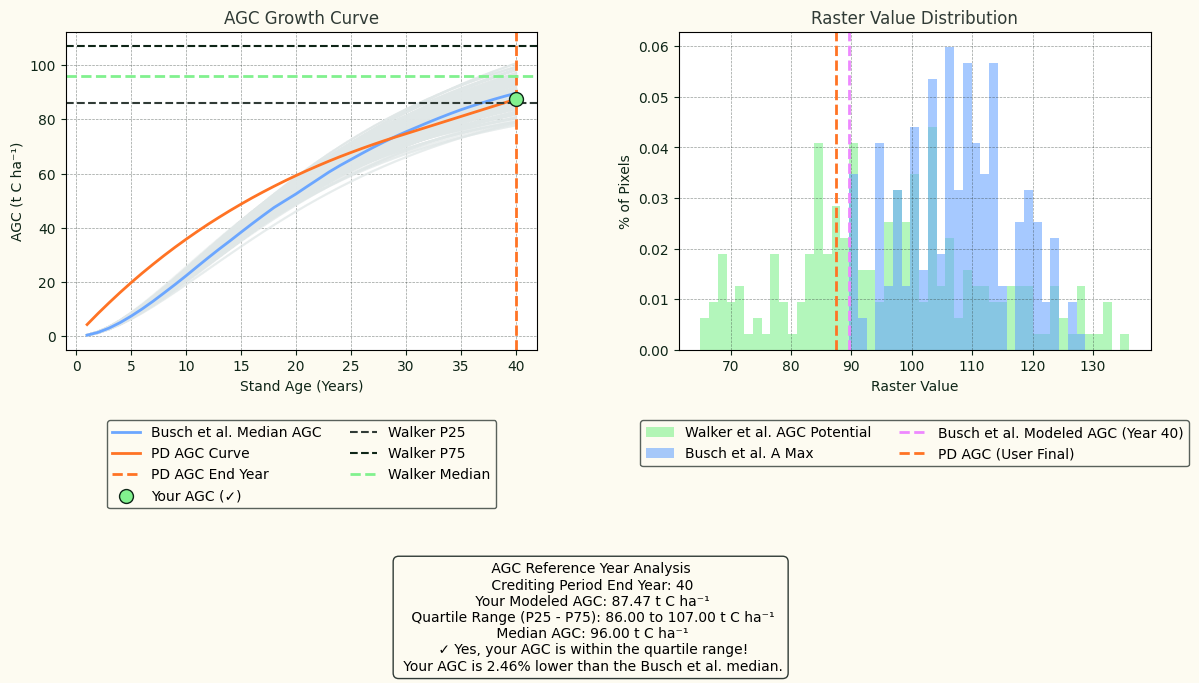

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload and Read User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison CSV ----
raster_csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(raster_csv_path)

# Extract values for Walker et al.
raster1_values = df["Raster1_Value"].dropna().values
raster1_p25 = np.percentile(raster1_values, 25)
raster1_p75 = np.percentile(raster1_values, 75)
raster1_median = np.median(raster1_values)

# Generate Chapman-Richards Growth Curves (Busch et al.)
t_max = crediting_period
t_values = np.arange(1, t_max + 1)
agc_curves = []

for _, row in df.iterrows():
    A = row["Raster2_BandA_Value"]
    k = row["Raster2_BandK_Value"]
    AGC = A * (1 - np.exp(-k * t_values)) ** 2
    agc_curves.append(AGC)

median_agc_curve = np.median(agc_curves, axis=0)
busch_median_agc_end = median_agc_curve[-1]  # Last value in the median curve

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze color for PD AGC Curve
color_lidar_green = "#81F18E"
color_eggshell = "#FDFBF1"
color_pine = "#0E2517"
color_charcoal = "#303B36"
color_white = "#FFFFFF"
color_flax = "#6BA6FF"
color_pearl = "#E0E7E7"
color_hibiscus = "#EE88FF"

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left) ----
ax1 = axes[0]

# Plot Busch et al. AGC Curves
for curve in agc_curves:
    ax1.plot(t_values, curve, color=color_pearl, alpha=0.5)

ax1.plot(t_values, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al. Median AGC")

# Plot PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2, label="PD AGC Curve")

# Plot Vertical Line at End of Crediting Period
ax1.axvline(crediting_period, color=color_pd_agc, linestyle="dashed", linewidth=2, label="PD AGC End Year")

# User AGC Marker
marker_style = "✓" if raster1_p25 <= user_agc <= raster1_p75 else "✗"
marker_color = color_lidar_green if raster1_p25 <= user_agc <= raster1_p75 else "red"
ax1.scatter(crediting_period, user_agc, color=marker_color, s=100, edgecolor=color_pine, label=f"Your AGC ({marker_style})", zorder=3)

# Walker Lines (P25, P75, Median)
ax1.axhline(raster1_p25, color=color_charcoal, linestyle="dashed", linewidth=1.5, label="Walker P25")
ax1.axhline(raster1_p75, color=color_pine, linestyle="dashed", linewidth=1.5, label="Walker P75")
ax1.axhline(raster1_median, color=color_lidar_green, linestyle="dashed", linewidth=2, label="Walker Median")

ax1.set_xlabel("Stand Age (Years)", color=color_pine)
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine)
ax1.set_title("AGC Growth Curve", color=color_charcoal)
ax1.tick_params(colors=color_pine)
ax1.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 2️⃣ Raster Value Distribution (Right) ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), df["Raster2_BandA_Value"].min()),
                   max(raster1_values.max(), df["Raster2_BandA_Value"].max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al. AGC Potential", density=True)
ax2.hist(df["Raster2_BandA_Value"], bins, alpha=0.6, color=color_flax, label="Busch et al. A Max", density=True)

# Vertical Line for Busch Median AGC at End of Crediting Period
ax2.axvline(busch_median_agc_end, color=color_hibiscus, linestyle="dashed", linewidth=2,
            label=f"Busch et al. Modeled AGC (Year {crediting_period})")

# Vertical Line for PD AGC (Final Value in User CSV)
ax2.axvline(user_agc, color=color_pd_agc, linestyle="dashed", linewidth=2, label="PD AGC (User Final)")

ax2.set_xlabel("Raster Value", color=color_pine)
ax2.set_ylabel("% of Pixels", color=color_pine)
ax2.set_title("Raster Value Distribution", color=color_charcoal)
ax2.tick_params(colors=color_pine)
ax2.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 📊 Overlay Analysis Text Below ----
percent_diff = ((user_agc - busch_median_agc_end) / busch_median_agc_end) * 100
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Crediting Period End Year: {crediting_period}\n"
    f" Your Modeled AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {raster1_p25:.2f} to {raster1_p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {raster1_median:.2f} t C ha⁻¹\n"
    f" {marker_style} {'Yes' if raster1_p25 <= user_agc <= raster1_p75 else 'No'}, your AGC is "
    f"{'within' if raster1_p25 <= user_agc <= raster1_p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(percent_diff):.2f}% {'higher' if percent_diff > 0 else 'lower'} than the Busch et al. median."
)

plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center", fontfamily="DejaVu Sans",
            bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (4).csv


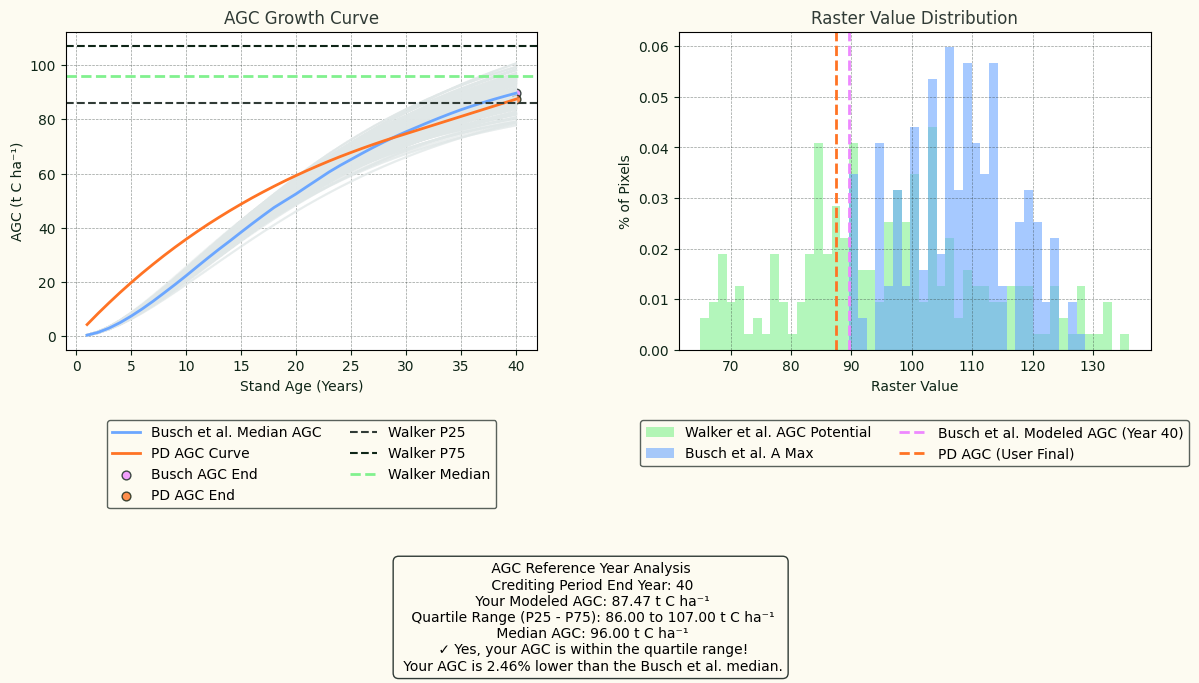

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload and Read User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison CSV ----
raster_csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(raster_csv_path)

# Extract values for Walker et al.
raster1_values = df["Raster1_Value"].dropna().values
raster1_p25 = np.percentile(raster1_values, 25)
raster1_p75 = np.percentile(raster1_values, 75)
raster1_median = np.median(raster1_values)

# Generate Chapman-Richards Growth Curves (Busch et al.)
t_max = crediting_period
t_values = np.arange(1, t_max + 1)
agc_curves = []

for _, row in df.iterrows():
    A = row["Raster2_BandA_Value"]
    k = row["Raster2_BandK_Value"]
    AGC = A * (1 - np.exp(-k * t_values)) ** 2
    agc_curves.append(AGC)

median_agc_curve = np.median(agc_curves, axis=0)
busch_median_agc_end = median_agc_curve[-1]  # Last value in the median curve

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze color for PD AGC Marker
color_busch_marker = "#EE88FF"  # Hibiscus color for Busch AGC Marker
color_lidar_green = "#81F18E"
color_eggshell = "#FDFBF1"
color_pine = "#0E2517"
color_charcoal = "#303B36"
color_white = "#FFFFFF"
color_flax = "#6BA6FF"
color_pearl = "#E0E7E7"

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left) ----
ax1 = axes[0]

# Plot Busch et al. AGC Curves
for curve in agc_curves:
    ax1.plot(t_values, curve, color=color_pearl, alpha=0.5)

ax1.plot(t_values, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al. Median AGC")

# Plot PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2, label="PD AGC Curve")

# Adjust marker visibility by slightly shifting if they overlap
offset = 0.3 if abs(user_agc - busch_median_agc_end) < 0.5 else 0

# Small Markers for AGC at End of Crediting Period
ax1.scatter(crediting_period, busch_median_agc_end + offset, color=color_busch_marker, s=40, edgecolor=color_pine, alpha=0.8, label="Busch AGC End")
ax1.scatter(crediting_period, user_agc - offset, color=color_pd_agc, s=40, edgecolor=color_pine, alpha=0.8, label="PD AGC End")

# Walker Lines (P25, P75, Median)
ax1.axhline(raster1_p25, color=color_charcoal, linestyle="dashed", linewidth=1.5, label="Walker P25")
ax1.axhline(raster1_p75, color=color_pine, linestyle="dashed", linewidth=1.5, label="Walker P75")
ax1.axhline(raster1_median, color=color_lidar_green, linestyle="dashed", linewidth=2, label="Walker Median")

ax1.set_xlabel("Stand Age (Years)", color=color_pine)
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine)
ax1.set_title("AGC Growth Curve", color=color_charcoal)
ax1.tick_params(colors=color_pine)
ax1.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 2️⃣ Raster Value Distribution (Right) ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), df["Raster2_BandA_Value"].min()),
                   max(raster1_values.max(), df["Raster2_BandA_Value"].max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al. AGC Potential", density=True)
ax2.hist(df["Raster2_BandA_Value"], bins, alpha=0.6, color=color_flax, label="Busch et al. A Max", density=True)

# Vertical Line for Busch Median AGC at End of Crediting Period
ax2.axvline(busch_median_agc_end, color=color_busch_marker, linestyle="dashed", linewidth=2,
            label=f"Busch et al. Modeled AGC (Year {crediting_period})")

# Vertical Line for PD AGC (Final Value in User CSV)
ax2.axvline(user_agc, color=color_pd_agc, linestyle="dashed", linewidth=2, label="PD AGC (User Final)")

ax2.set_xlabel("Raster Value", color=color_pine)
ax2.set_ylabel("% of Pixels", color=color_pine)
ax2.set_title("Raster Value Distribution", color=color_charcoal)
ax2.tick_params(colors=color_pine)
ax2.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 📊 Overlay Analysis Text Below ----
percent_diff = ((user_agc - busch_median_agc_end) / busch_median_agc_end) * 100
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Crediting Period End Year: {crediting_period}\n"
    f" Your Modeled AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {raster1_p25:.2f} to {raster1_p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {raster1_median:.2f} t C ha⁻¹\n"
    f" {'✓' if raster1_p25 <= user_agc <= raster1_p75 else '✗'} {'Yes' if raster1_p25 <= user_agc <= raster1_p75 else 'No'}, your AGC is "
    f"{'within' if raster1_p25 <= user_agc <= raster1_p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(percent_diff):.2f}% {'higher' if percent_diff > 0 else 'lower'} than the Busch et al. median."
)

plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center", fontfamily="DejaVu Sans",
            bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (5).csv


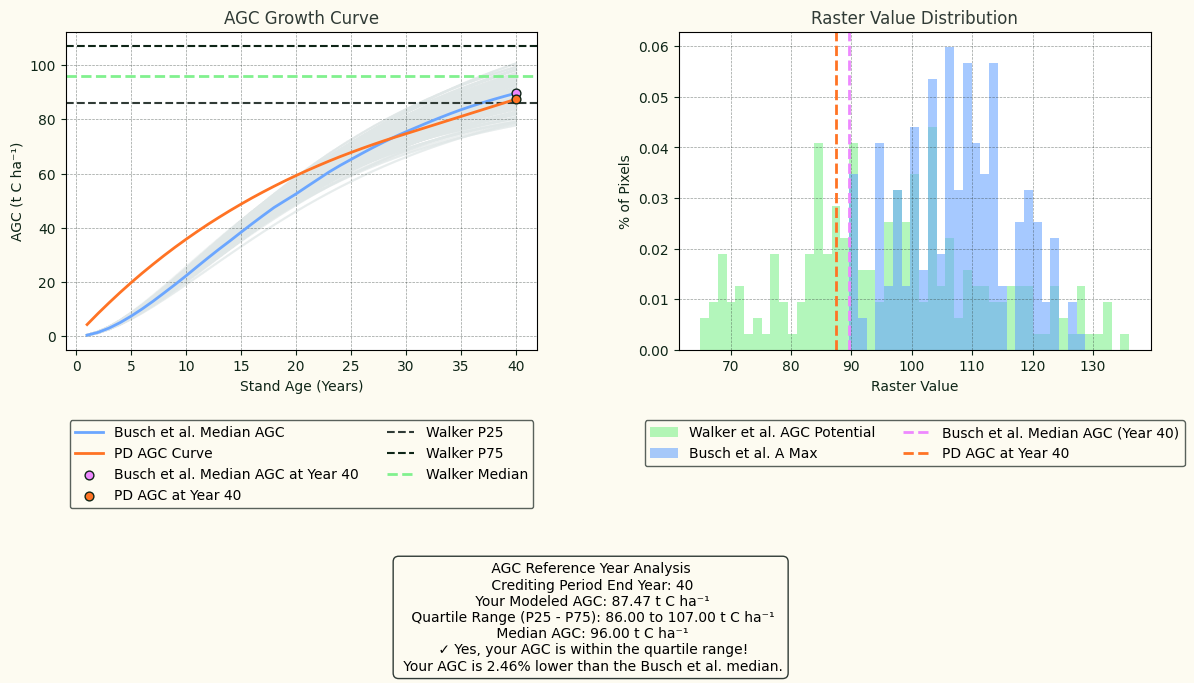

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload and Read User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison CSV ----
raster_csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(raster_csv_path)

# Extract values for Walker et al.
raster1_values = df["Raster1_Value"].dropna().values
raster1_p25 = np.percentile(raster1_values, 25)
raster1_p75 = np.percentile(raster1_values, 75)
raster1_median = np.median(raster1_values)

# Generate Chapman-Richards Growth Curves (Busch et al.)
t_max = crediting_period
t_values = np.arange(1, t_max + 1)
agc_curves = []

for _, row in df.iterrows():
    A = row["Raster2_BandA_Value"]
    k = row["Raster2_BandK_Value"]
    AGC = A * (1 - np.exp(-k * t_values)) ** 2
    agc_curves.append(AGC)

median_agc_curve = np.median(agc_curves, axis=0)
busch_median_agc_end = median_agc_curve[-1]  # Last value in the median curve

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze color for PD AGC Marker
color_busch_marker = "#EE88FF"  # Hibiscus color for Busch AGC Marker
color_pearl = "#E0E7E7"
color_flax = "#6BA6FF"
color_pine = "#0E2517"
color_charcoal = "#303B36"
color_lidar_green = "#81F18E"
color_eggshell = "#FDFBF1"

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left) ----
ax1 = axes[0]

# Plot Busch et al. AGC Curves
for curve in agc_curves:
    ax1.plot(t_values, curve, color=color_pearl, alpha=0.5, zorder=1)

ax1.plot(t_values, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al. Median AGC", zorder=2)

# Plot PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2, label="PD AGC Curve", zorder=3)

# Markers for AGC at End of Crediting Period (Ensuring they are on top)
ax1.scatter(crediting_period, busch_median_agc_end, color=color_busch_marker, s=40, edgecolor=color_pine, alpha=1, label=f"Busch et al. Median AGC at Year {crediting_period}", zorder=4)
ax1.scatter(crediting_period, user_agc, color=color_pd_agc, s=40, edgecolor=color_pine, alpha=1, label=f"PD AGC at Year {crediting_period}", zorder=5)

# Walker Lines (P25, P75, Median)
ax1.axhline(raster1_p25, color=color_charcoal, linestyle="dashed", linewidth=1.5, label="Walker P25")
ax1.axhline(raster1_p75, color=color_pine, linestyle="dashed", linewidth=1.5, label="Walker P75")
ax1.axhline(raster1_median, color=color_lidar_green, linestyle="dashed", linewidth=2, label="Walker Median")

ax1.set_xlabel("Stand Age (Years)", color=color_pine)
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine)
ax1.set_title("AGC Growth Curve", color=color_charcoal)
ax1.tick_params(colors=color_pine)
ax1.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 2️⃣ Raster Value Distribution (Right) ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), df["Raster2_BandA_Value"].min()),
                   max(raster1_values.max(), df["Raster2_BandA_Value"].max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al. AGC Potential", density=True)
ax2.hist(df["Raster2_BandA_Value"], bins, alpha=0.6, color=color_flax, label="Busch et al. A Max", density=True)

# Vertical Line for Busch Median AGC at End of Crediting Period
ax2.axvline(busch_median_agc_end, color=color_busch_marker, linestyle="dashed", linewidth=2,
            label=f"Busch et al. Median AGC (Year {crediting_period})")

# Vertical Line for PD AGC (Final Value in User CSV)
ax2.axvline(user_agc, color=color_pd_agc, linestyle="dashed", linewidth=2, label=f"PD AGC at Year {crediting_period}")

ax2.set_xlabel("Raster Value", color=color_pine)
ax2.set_ylabel("% of Pixels", color=color_pine)
ax2.set_title("Raster Value Distribution", color=color_charcoal)
ax2.tick_params(colors=color_pine)
ax2.grid(color=color_charcoal, linestyle="--", linewidth=0.5, alpha=0.5)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 📊 Overlay Analysis Text Below ----
percent_diff = ((user_agc - busch_median_agc_end) / busch_median_agc_end) * 100
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Crediting Period End Year: {crediting_period}\n"
    f" Your Modeled AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {raster1_p25:.2f} to {raster1_p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {raster1_median:.2f} t C ha⁻¹\n"
    f" {'✓' if raster1_p25 <= user_agc <= raster1_p75 else '✗'} {'Yes' if raster1_p25 <= user_agc <= raster1_p75 else 'No'}, your AGC is "
    f"{'within' if raster1_p25 <= user_agc <= raster1_p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(percent_diff):.2f}% {'higher' if percent_diff > 0 else 'lower'} than the Busch et al. median."
)

plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center", fontfamily="DejaVu Sans",
            bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (7).csv


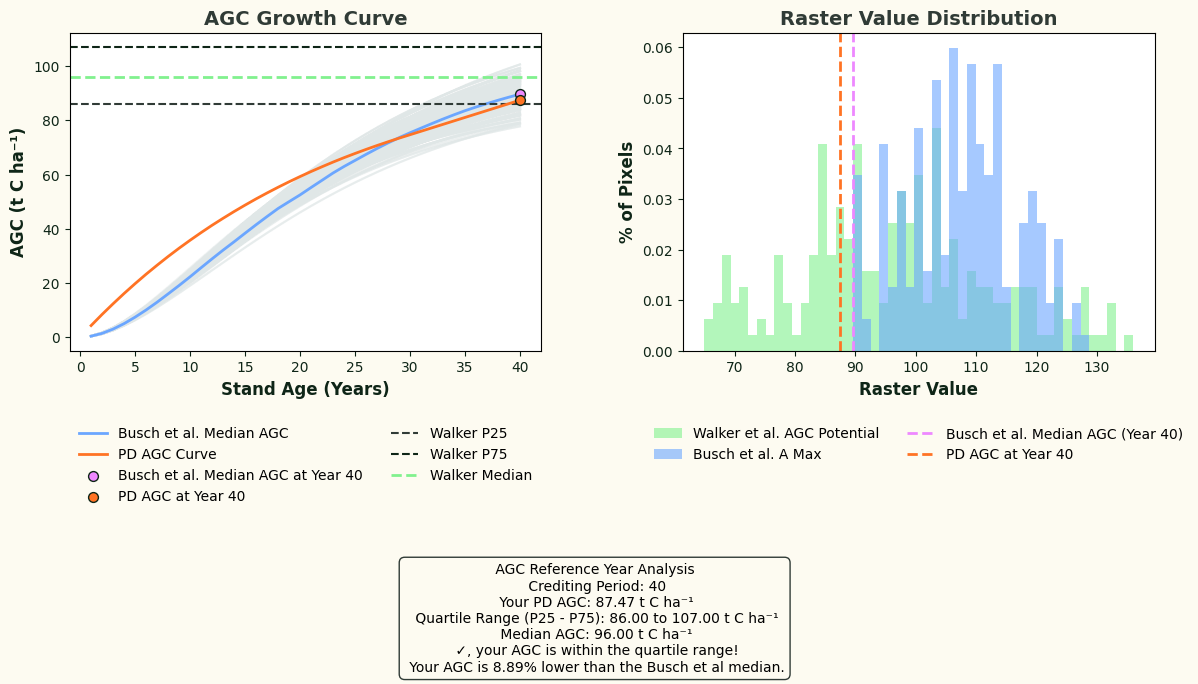

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload and Read User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison CSV ----
raster_csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(raster_csv_path)

# Extract values for Walker et al.
raster1_values = df["Raster1_Value"].dropna().values
raster1_p25 = np.percentile(raster1_values, 25)
raster1_p75 = np.percentile(raster1_values, 75)
raster1_median = np.median(raster1_values)

# Generate Chapman-Richards Growth Curves (Busch et al.)
t_max = crediting_period
t_values = np.arange(1, t_max + 1)
agc_curves = []

for _, row in df.iterrows():
    A = row["Raster2_BandA_Value"]
    k = row["Raster2_BandK_Value"]
    AGC = A * (1 - np.exp(-k * t_values)) ** 2
    agc_curves.append(AGC)

median_agc_curve = np.median(agc_curves, axis=0)
busch_median_agc_end = median_agc_curve[-1]  # Last value in the median curve

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze color for PD AGC Marker
color_busch_marker = "#EE88FF"  # Hibiscus color for Busch AGC Marker
color_pearl = "#E0E7E7"
color_flax = "#6BA6FF"
color_pine = "#0E2517"
color_charcoal = "#303B36"
color_lidar_green = "#81F18E"
color_eggshell = "#FDFBF1"

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left) ----
ax1 = axes[0]

# Plot Busch et al. AGC Curves
for curve in agc_curves:
    ax1.plot(t_values, curve, color=color_pearl, alpha=0.5, zorder=1)

ax1.plot(t_values, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al. Median AGC", zorder=2)

# Plot PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2, label="PD AGC Curve", zorder=3)

# Markers for AGC at End of Crediting Period (Ensuring they are on top)
ax1.scatter(crediting_period, busch_median_agc_end, color=color_busch_marker, s=50, edgecolor=color_pine, alpha=1, label=f"Busch et al. Median AGC at Year {crediting_period}", zorder=4)
ax1.scatter(crediting_period, user_agc, color=color_pd_agc, s=50, edgecolor=color_pine, alpha=1, label=f"PD AGC at Year {crediting_period}", zorder=5)

# Walker Lines (P25, P75, Median)
ax1.axhline(raster1_p25, color=color_charcoal, linestyle="dashed", linewidth=1.5, label="Walker P25")
ax1.axhline(raster1_p75, color=color_pine, linestyle="dashed", linewidth=1.5, label="Walker P75")
ax1.axhline(raster1_median, color=color_lidar_green, linestyle="dashed", linewidth=2, label="Walker Median")

ax1.set_xlabel("Stand Age (Years)", color=color_pine, fontsize=12, fontweight="bold")
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine, fontsize=12, fontweight="bold")
ax1.set_title("AGC Growth Curve", color=color_charcoal, fontsize=14, fontweight="bold")
ax1.tick_params(colors=color_pine)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=2)

# ---- 2️⃣ Raster Value Distribution (Right) ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), df["Raster2_BandA_Value"].min()),
                   max(raster1_values.max(), df["Raster2_BandA_Value"].max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al. AGC Potential", density=True)
ax2.hist(df["Raster2_BandA_Value"], bins, alpha=0.6, color=color_flax, label="Busch et al. A Max", density=True)

# Vertical Line for Busch Median AGC at End of Crediting Period
ax2.axvline(busch_median_agc_end, color=color_busch_marker, linestyle="dashed", linewidth=2,
            label=f"Busch et al. Median AGC (Year {crediting_period})")

# Vertical Line for PD AGC (Final Value in User CSV)
ax2.axvline(user_agc, color=color_pd_agc, linestyle="dashed", linewidth=2, label=f"PD AGC at Year {crediting_period}")

ax2.set_xlabel("Raster Value", color=color_pine, fontsize=12, fontweight="bold")
ax2.set_ylabel("% of Pixels", color=color_pine, fontsize=12, fontweight="bold")
ax2.set_title("Raster Value Distribution", color=color_charcoal, fontsize=14, fontweight="bold")
ax2.tick_params(colors=color_pine)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=False, ncol=2)

# ---- 📊 Overlay Analysis Text ----
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Crediting Period: {crediting_period}\n"
    f" Your PD AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {p25:.2f} to {p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {median_agc:.2f} t C ha⁻¹\n"
    f" {'✓' if p25 <= user_agc <= p75 else '✗'}, your AGC is "
    f"{'within' if p25 <= user_agc <= p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(((user_agc - median_agc) / median_agc) * 100):.2f}% "
    f"{'higher' if user_agc > median_agc else 'lower'} than the Busch et al median."
)

plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center",
            fontfamily="DejaVu Sans", bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()



Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (8).csv


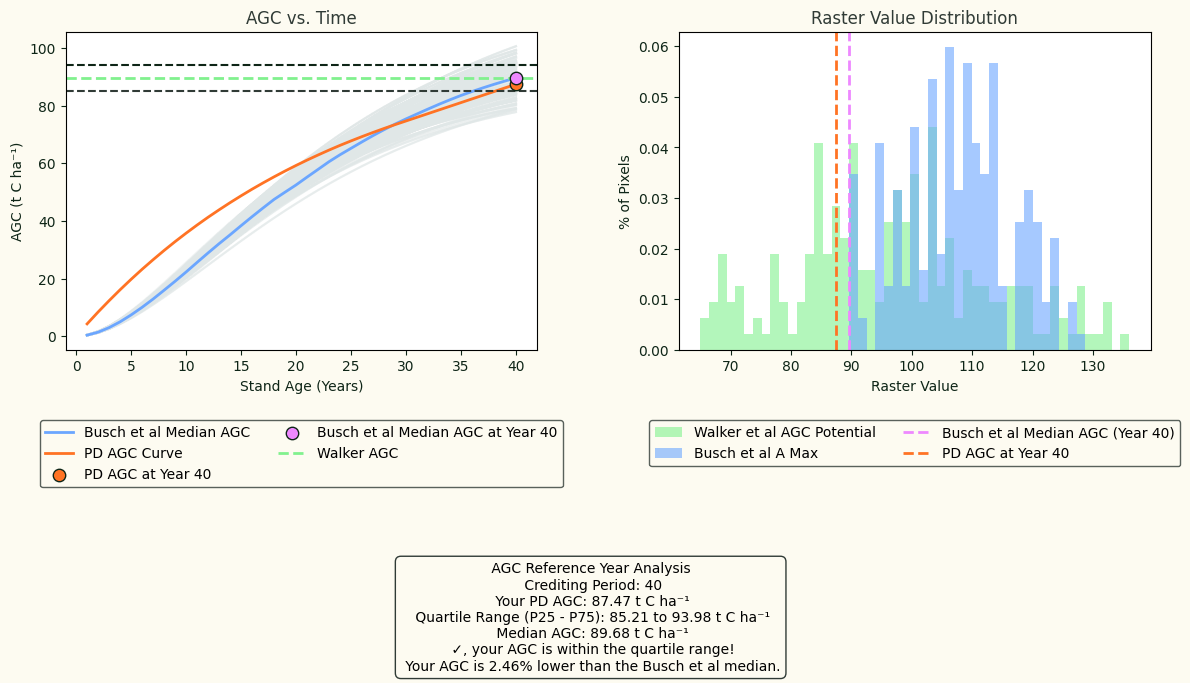

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding PD AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison Data ----
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# ---- Compute Busch et al AGC Statistics at Crediting Period ----
busch_agc_end_values = [curve[years == crediting_period][0] for curve in agc_curves if crediting_period in years]
p25 = np.percentile(busch_agc_end_values, 25)
p75 = np.percentile(busch_agc_end_values, 75)
median_agc = np.median(busch_agc_end_values)

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze (PD AGC Curve)
color_lidar_green = "#81F18E"  # Walker et al AGC
color_eggshell = "#FDFBF1"  # Background
color_pine = "#0E2517"  # Axis & Text
color_charcoal = "#303B36"  # Grid lines & separators
color_white = "#FFFFFF"  # Text Box
color_flax = "#6BA6FF"  # Busch et al A Max
color_pearl = "#E0E7E7"  # Busch et al AGC Curves
color_hibiscus = "#EE88FF"  # Busch AGC End Marker

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left Side) ----
ax1 = axes[0]

# Busch et al AGC Curves (Pearl Color)
for curve in agc_curves:
    ax1.plot(years, curve, color=color_pearl, alpha=0.5)

# Busch et al Median AGC Curve (Flax Color)
median_agc_curve = np.median(agc_curves, axis=0)
ax1.plot(years, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al Median AGC")

# Overlay PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2, label="PD AGC Curve")

# Markers for PD AGC and Busch AGC at the End of Crediting Period
ax1.scatter(crediting_period, user_agc, color=color_pd_agc, edgecolor=color_pine, s=80, label=f"PD AGC at Year {crediting_period}", zorder=3)
ax1.scatter(crediting_period, median_agc, color=color_hibiscus, edgecolor=color_pine, s=80, label=f"Busch et al Median AGC at Year {crediting_period}", zorder=3)

# Walker et al P25, P75, and Median Lines
ax1.axhline(p25, color=color_charcoal, linestyle='dashed', linewidth=1.5)
ax1.axhline(p75, color=color_pine, linestyle='dashed', linewidth=1.5)
ax1.axhline(median_agc, color=color_lidar_green, linestyle='dashed', linewidth=2, label="Walker AGC")

ax1.set_xlabel("Stand Age (Years)", color=color_pine)
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine)
ax1.set_title("AGC vs. Time", color=color_charcoal)
ax1.tick_params(colors=color_pine)

# Remove grid for a cleaner look
ax1.grid(False)

# Move legend below the chart
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 2️⃣ Raster Histogram (Right Side) ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), raster2_bandA_values.min()), max(raster1_values.max(), raster2_bandA_values.max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al AGC Potential", density=True)
ax2.hist(raster2_bandA_values, bins, alpha=0.6, color=color_flax, label="Busch et al A Max", density=True)

# Vertical Lines for Final AGC Values
ax2.axvline(median_agc, color=color_hibiscus, linestyle='dashed', linewidth=2, label=f"Busch et al Median AGC (Year {crediting_period})")
ax2.axvline(user_agc, color=color_pd_agc, linestyle='dashed', linewidth=2, label=f"PD AGC at Year {crediting_period}")

ax2.set_xlabel("Raster Value", color=color_pine)
ax2.set_ylabel("% of Pixels", color=color_pine)
ax2.set_title("Raster Value Distribution", color=color_charcoal)
ax2.tick_params(colors=color_pine)

# Remove grid for a cleaner look
ax2.grid(False)

# Move legend below the chart
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 📊 Overlay Analysis Text ----
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Crediting Period: {crediting_period}\n"
    f" Your PD AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {p25:.2f} to {p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {median_agc:.2f} t C ha⁻¹\n"
    f" {'✓' if p25 <= user_agc <= p75 else '✗'}, your AGC is "
    f"{'within' if p25 <= user_agc <= p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(((user_agc - median_agc) / median_agc) * 100):.2f}% "
    f"{'higher' if user_agc > median_agc else 'lower'} than the Busch et al median."
)

plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center",
            fontfamily="DejaVu Sans", bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (15).csv


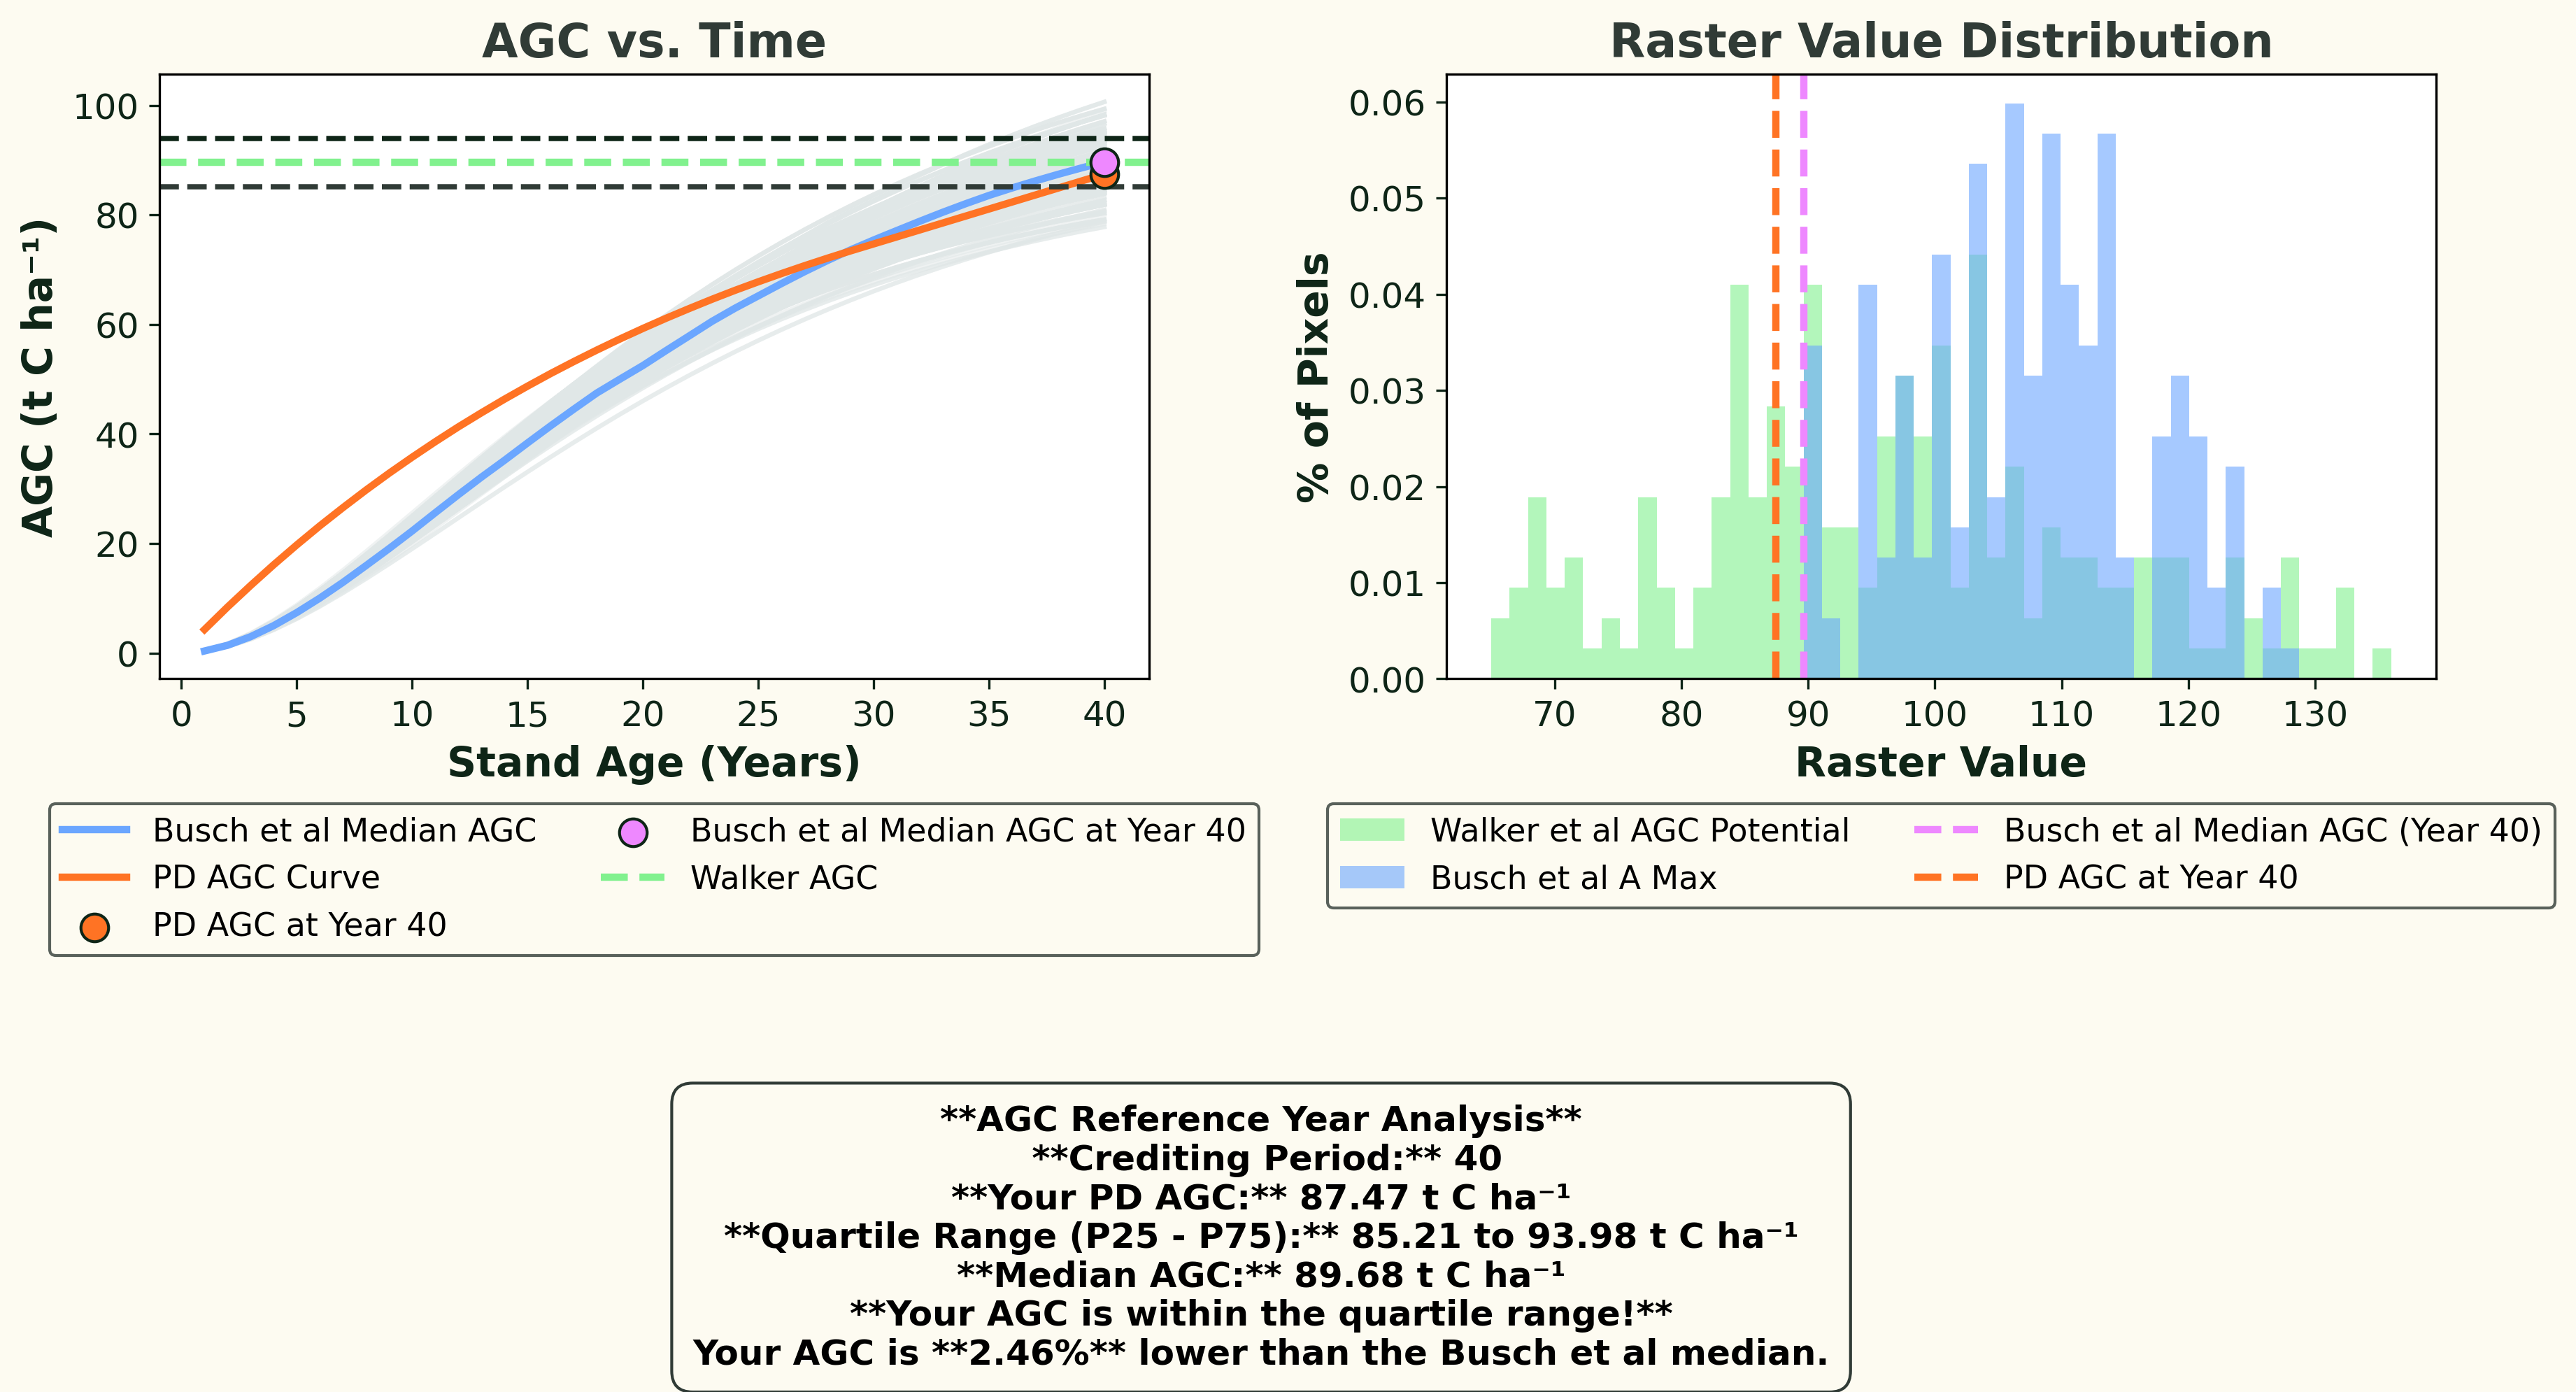

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding PD AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison Data ----
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# ---- Compute Busch et al AGC Statistics at Crediting Period ----
busch_agc_end_values = [curve[years == crediting_period][0] for curve in agc_curves if crediting_period in years]
p25 = np.percentile(busch_agc_end_values, 25)
p75 = np.percentile(busch_agc_end_values, 75)
median_agc = np.median(busch_agc_end_values)

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze (PD AGC Curve)
color_lidar_green = "#81F18E"  # Walker et al AGC
color_eggshell = "#FDFBF1"  # Background
color_pine = "#0E2517"  # Axis & Text
color_charcoal = "#303B36"  # Grid lines & separators
color_white = "#FFFFFF"  # Text Box
color_flax = "#6BA6FF"  # Busch et al A Max
color_pearl = "#E0E7E7"  # Busch et al AGC Curves
color_hibiscus = "#EE88FF"  # Busch AGC End Marker

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell, dpi=300)

# ---- 1️⃣ AGC Growth Curve (Left Side) ----
ax1 = axes[0]

# Busch et al AGC Curves (Pearl Color)
for curve in agc_curves:
    ax1.plot(years, curve, color=color_pearl, alpha=0.5)

# Busch et al Median AGC Curve (Flax Color)
median_agc_curve = np.median(agc_curves, axis=0)
ax1.plot(years, median_agc_curve, color=color_flax, linewidth=2.5, label="Busch et al Median AGC")

# Overlay PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2.5, label="PD AGC Curve")

# Markers for PD AGC and Busch AGC at the End of Crediting Period
ax1.scatter(crediting_period, user_agc, color=color_pd_agc, edgecolor=color_pine, s=90, label=f"PD AGC at Year {crediting_period}", zorder=3)
ax1.scatter(crediting_period, median_agc, color=color_hibiscus, edgecolor=color_pine, s=90, label=f"Busch et al Median AGC at Year {crediting_period}", zorder=3)

# Walker et al P25, P75, and Median Lines
ax1.axhline(p25, color=color_charcoal, linestyle='dashed', linewidth=1.8)
ax1.axhline(p75, color=color_pine, linestyle='dashed', linewidth=1.8)
ax1.axhline(median_agc, color=color_lidar_green, linestyle='dashed', linewidth=2.5, label="Walker AGC")

ax1.set_xlabel("Stand Age (Years)", fontsize=14, color=color_pine, fontweight="bold")
ax1.set_ylabel("AGC (t C ha⁻¹)", fontsize=14, color=color_pine, fontweight="bold")
ax1.set_title("AGC vs. Time", fontsize=16, color=color_charcoal, fontweight="bold")
ax1.tick_params(axis="both", labelsize=12, colors=color_pine)

# Remove grid for a cleaner look
ax1.grid(False)

# Move legend below the chart
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2, fontsize=11)

# ---- 2️⃣ Raster Histogram (Right Side) ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), raster2_bandA_values.min()), max(raster1_values.max(), raster2_bandA_values.max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al AGC Potential", density=True)
ax2.hist(raster2_bandA_values, bins, alpha=0.6, color=color_flax, label="Busch et al A Max", density=True)

# Vertical Lines for Final AGC Values
ax2.axvline(median_agc, color=color_hibiscus, linestyle='dashed', linewidth=2.5, label=f"Busch et al Median AGC (Year {crediting_period})")
ax2.axvline(user_agc, color=color_pd_agc, linestyle='dashed', linewidth=2.5, label=f"PD AGC at Year {crediting_period}")

ax2.set_xlabel("Raster Value", fontsize=14, color=color_pine, fontweight="bold")
ax2.set_ylabel("% of Pixels", fontsize=14, color=color_pine, fontweight="bold")
ax2.set_title("Raster Value Distribution", fontsize=16, color=color_charcoal, fontweight="bold")
ax2.tick_params(axis="both", labelsize=12, colors=color_pine)

# Remove grid for a cleaner look
ax2.grid(False)

# Move legend below the chart
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2, fontsize=11)

# ---- 📊 Overlay Analysis Text ----
analysis_text = (
    f"**AGC Reference Year Analysis**\n"
    f" **Crediting Period:** {crediting_period}\n"
    f"**Your PD AGC:** {user_agc:.2f} t C ha⁻¹\n"
    f"**Quartile Range (P25 - P75):** {p25:.2f} to {p75:.2f} t C ha⁻¹\n"
    f"**Median AGC:** {median_agc:.2f} t C ha⁻¹\n"
    f"**Your AGC is {'within' if p25 <= user_agc <= p75 else 'outside'} the quartile range!**\n"
    f"Your AGC is **{abs(((user_agc - median_agc) / median_agc) * 100):.2f}%** "
    f"{'higher' if user_agc > median_agc else 'lower'} than the Busch et al median."
)

plt.figtext(0.5, -0.14, analysis_text, wrap=True, fontsize=12, ha="center",
            fontweight="bold", fontfamily="DejaVu Sans", bbox=dict(boxstyle="round,pad=0.6", edgecolor=color_charcoal, facecolor=color_eggshell))

# ---- Adjust Layout ----
plt.subplots_adjust(bottom=0.4, wspace=0.3)

# ---- Show & Save ----
plt.savefig("AGC_Analysis.png", dpi=300, bbox_inches="tight")
plt.savefig("AGC_Analysis.pdf", dpi=300, bbox_inches="tight")

plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (11).csv


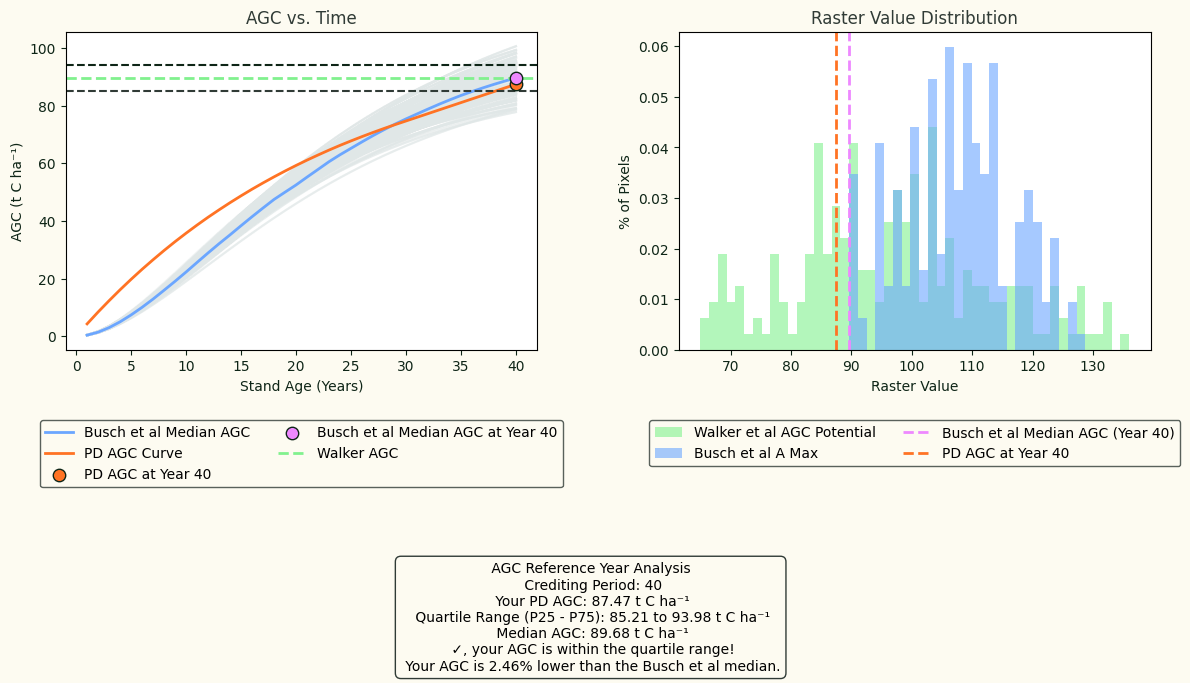

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding PD AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison Data ----
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# ---- Compute Busch et al AGC Statistics at Crediting Period ----
busch_agc_end_values = [curve[years == crediting_period][0] for curve in agc_curves if crediting_period in years]
p25 = np.percentile(busch_agc_end_values, 25)
p75 = np.percentile(busch_agc_end_values, 75)
median_agc = np.median(busch_agc_end_values)

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze (PD AGC Curve)
color_lidar_green = "#81F18E"  # Walker et al AGC
color_eggshell = "#FDFBF1"  # Background
color_pine = "#0E2517"  # Axis & Text
color_charcoal = "#303B36"  # Grid lines & separators
color_white = "#FFFFFF"  # Text Box
color_flax = "#6BA6FF"  # Busch et al A Max
color_pearl = "#E0E7E7"  # Busch et al AGC Curves
color_hibiscus = "#EE88FF"  # Busch AGC End Marker

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell)

# ---- 1️⃣ AGC Growth Curve (Left Side) ----
ax1 = axes[0]

# Busch et al AGC Curves (Pearl Color)
for curve in agc_curves:
    ax1.plot(years, curve, color=color_pearl, alpha=0.5)

# Busch et al Median AGC Curve (Flax Color)
median_agc_curve = np.median(agc_curves, axis=0)
ax1.plot(years, median_agc_curve, color=color_flax, linewidth=2, label="Busch et al Median AGC")

# Overlay PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2, label="PD AGC Curve")

# Markers for PD AGC and Busch AGC at the End of Crediting Period
ax1.scatter(crediting_period, user_agc, color=color_pd_agc, edgecolor=color_pine, s=80, label=f"PD AGC at Year {crediting_period}", zorder=3)
ax1.scatter(crediting_period, median_agc, color=color_hibiscus, edgecolor=color_pine, s=80, label=f"Busch et al Median AGC at Year {crediting_period}", zorder=3)

# Walker et al P25, P75, and Median Lines
ax1.axhline(p25, color=color_charcoal, linestyle='dashed', linewidth=1.5)
ax1.axhline(p75, color=color_pine, linestyle='dashed', linewidth=1.5)
ax1.axhline(median_agc, color=color_lidar_green, linestyle='dashed', linewidth=2, label="Walker AGC")

ax1.set_xlabel("Stand Age (Years)", color=color_pine)
ax1.set_ylabel("AGC (t C ha⁻¹)", color=color_pine)
ax1.set_title("AGC vs. Time", color=color_charcoal)
ax1.tick_params(colors=color_pine)

# Remove grid for a cleaner look
ax1.grid(False)

# Move legend below the chart
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 2️⃣ Raster Histogram (Right Side) ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), raster2_bandA_values.min()), max(raster1_values.max(), raster2_bandA_values.max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al AGC Potential", density=True)
ax2.hist(raster2_bandA_values, bins, alpha=0.6, color=color_flax, label="Busch et al A Max", density=True)

# Vertical Lines for Final AGC Values
ax2.axvline(median_agc, color=color_hibiscus, linestyle='dashed', linewidth=2, label=f"Busch et al Median AGC (Year {crediting_period})")
ax2.axvline(user_agc, color=color_pd_agc, linestyle='dashed', linewidth=2, label=f"PD AGC at Year {crediting_period}")

ax2.set_xlabel("Raster Value", color=color_pine)
ax2.set_ylabel("% of Pixels", color=color_pine)
ax2.set_title("Raster Value Distribution", color=color_charcoal)
ax2.tick_params(colors=color_pine)

# Remove grid for a cleaner look
ax2.grid(False)

# Move legend below the chart
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2)

# ---- 📊 Overlay Analysis Text ----
analysis_text = (
    f" AGC Reference Year Analysis \n"
    f" Crediting Period: {crediting_period}\n"
    f" Your PD AGC: {user_agc:.2f} t C ha⁻¹\n"
    f" Quartile Range (P25 - P75): {p25:.2f} to {p75:.2f} t C ha⁻¹\n"
    f" Median AGC: {median_agc:.2f} t C ha⁻¹\n"
    f" {'✓' if p25 <= user_agc <= p75 else '✗'}, your AGC is "
    f"{'within' if p25 <= user_agc <= p75 else 'outside'} the quartile range!\n"
    f" Your AGC is {abs(((user_agc - median_agc) / median_agc) * 100):.2f}% "
    f"{'higher' if user_agc > median_agc else 'lower'} than the Busch et al median."
)

plt.figtext(0.5, -0.18, analysis_text, wrap=True, fontsize=10, ha="center",
            fontfamily="DejaVu Sans", bbox=dict(boxstyle="round,pad=0.4", edgecolor=color_charcoal, facecolor=color_eggshell))

plt.subplots_adjust(bottom=0.35, wspace=0.3)
plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (17).csv


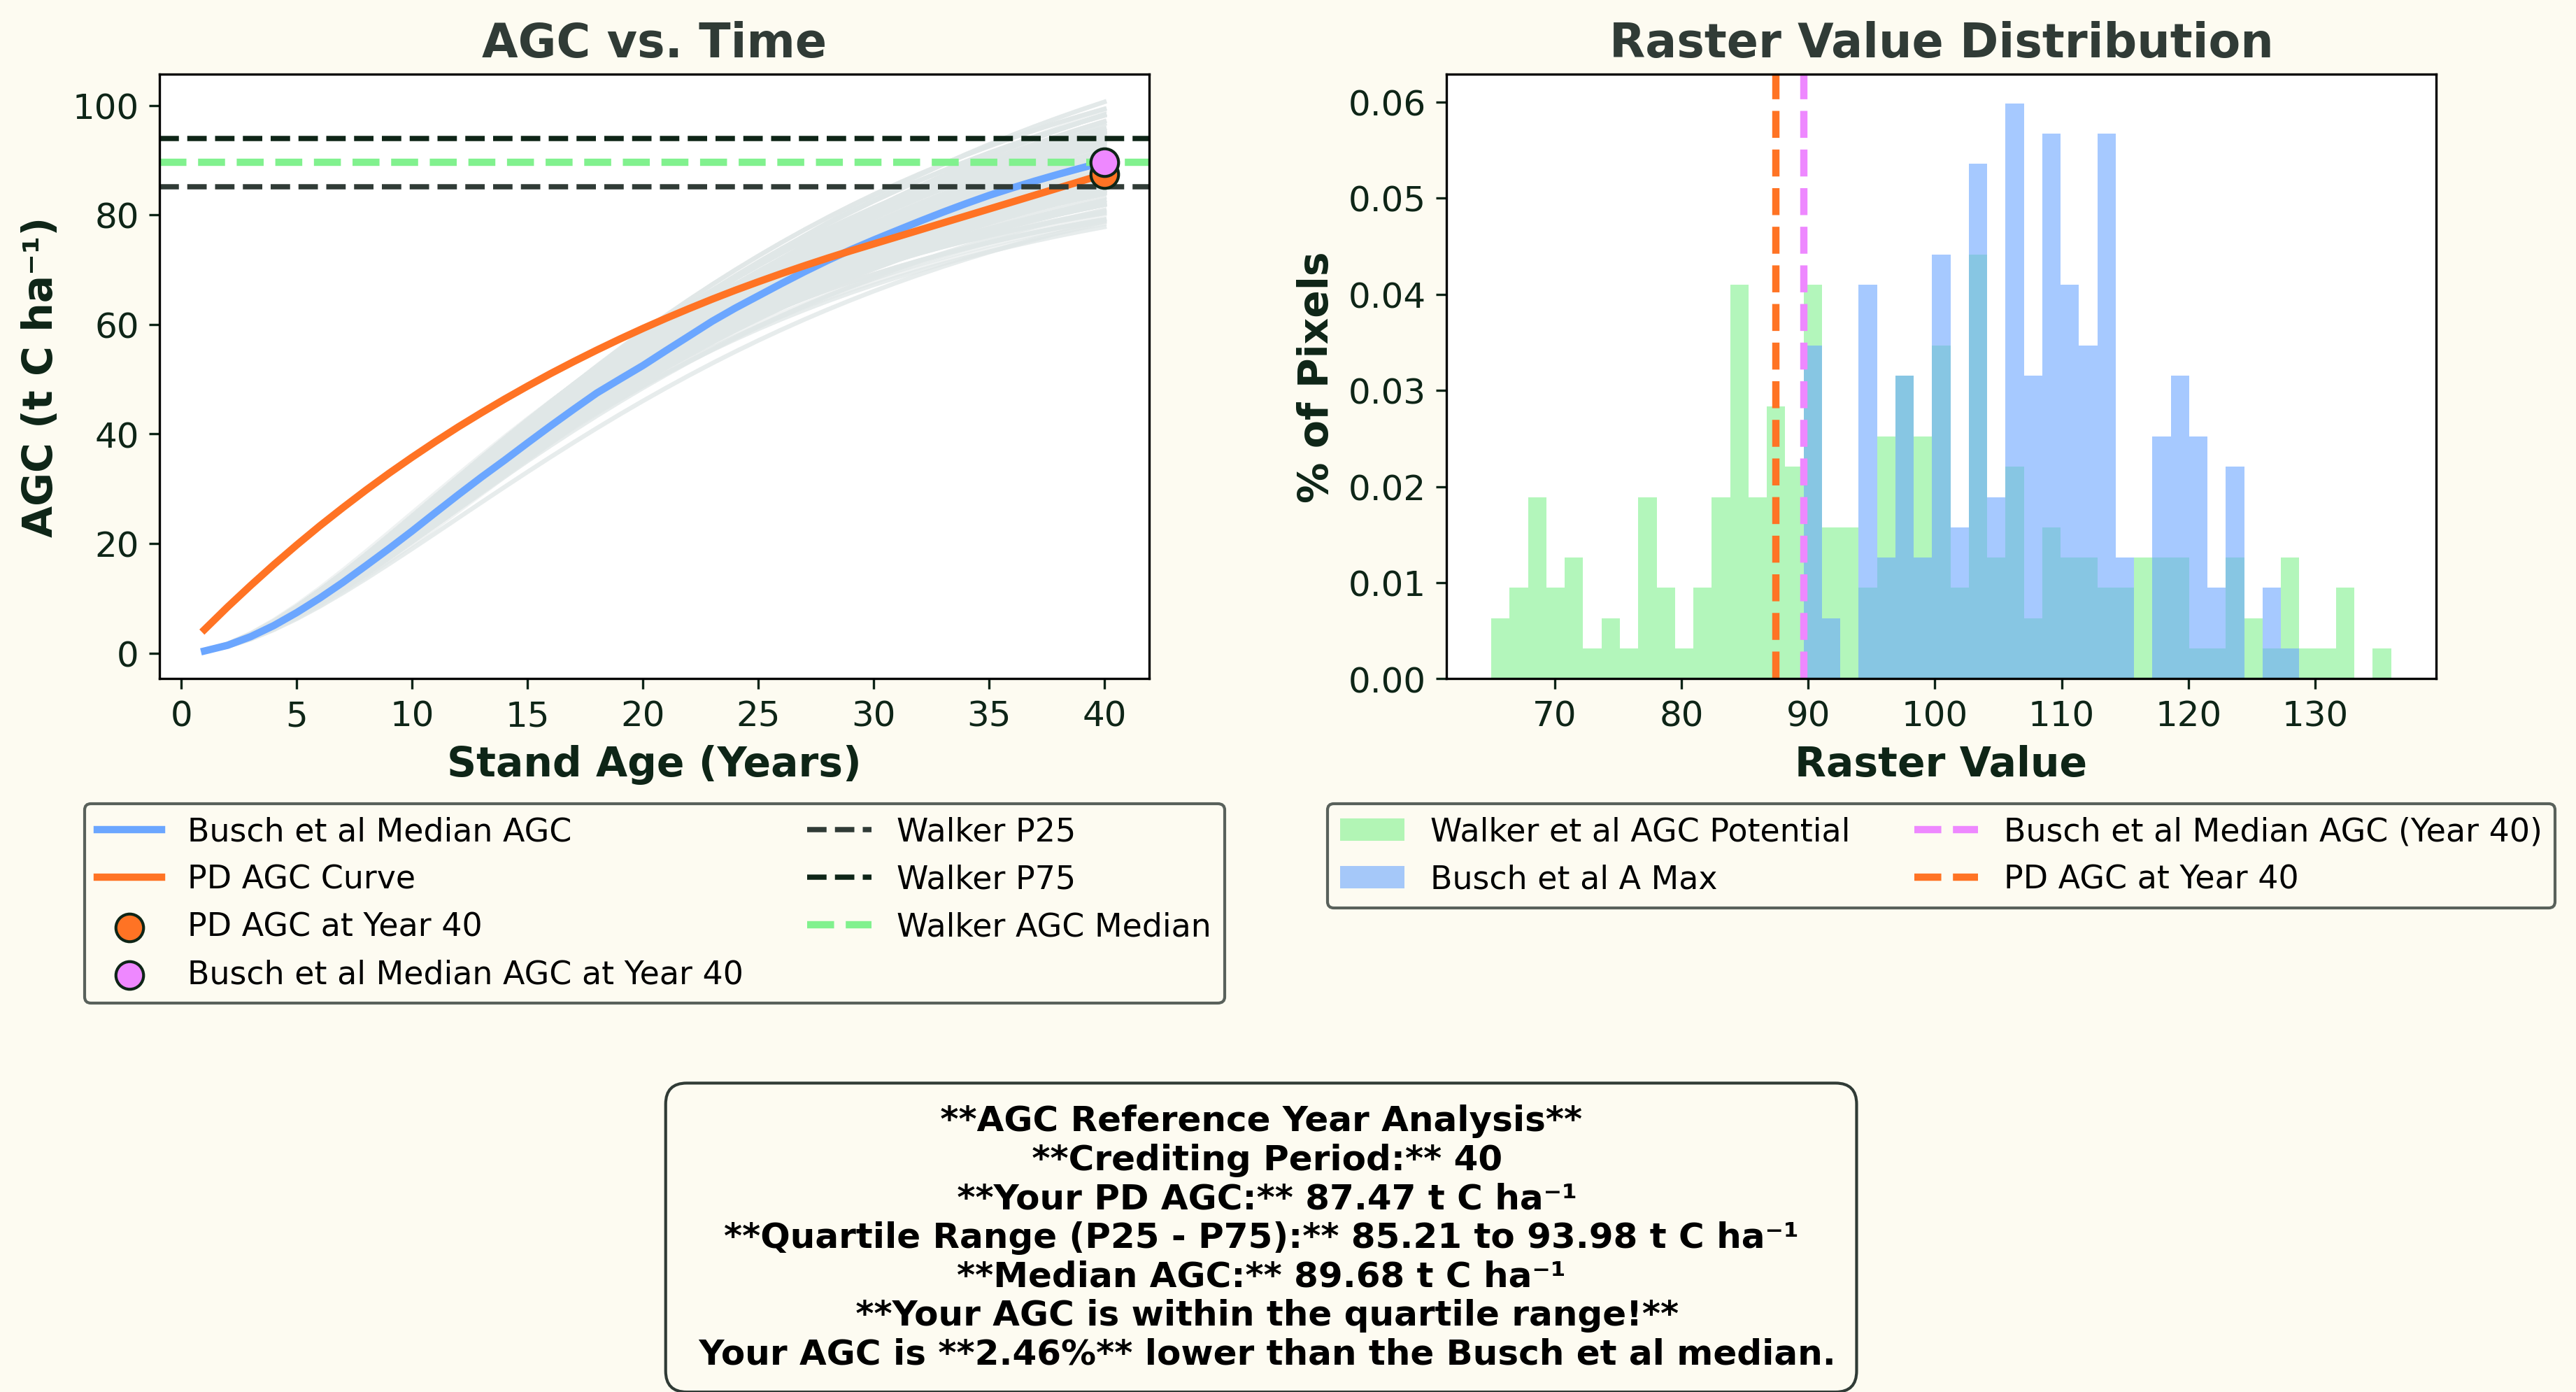

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding PD AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison Data ----
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# ---- Compute Busch et al AGC Statistics at Crediting Period ----
busch_agc_end_values = [curve[years == crediting_period][0] for curve in agc_curves if crediting_period in years]
p25 = np.percentile(busch_agc_end_values, 25)
p75 = np.percentile(busch_agc_end_values, 75)
median_agc = np.median(busch_agc_end_values)

# ---- Define Colors ----
color_pd_agc = "#FF7324"  # Blaze (PD AGC Curve)
color_lidar_green = "#81F18E"  # Walker et al AGC
color_eggshell = "#FDFBF1"  # Background
color_pine = "#0E2517"  # Axis & Text
color_charcoal = "#303B36"  # Grid lines & separators
color_white = "#FFFFFF"  # Text Box
color_flax = "#6BA6FF"  # Busch et al A Max
color_pearl = "#E0E7E7"  # Busch et al AGC Curves
color_hibiscus = "#EE88FF"  # Busch AGC End Marker

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell, dpi=300)

# ---- 1️⃣ AGC Growth Curve (Left Side) ----
ax1 = axes[0]

# Busch et al AGC Curves (Pearl Color)
for curve in agc_curves:
    ax1.plot(years, curve, color=color_pearl, alpha=0.5)

# Busch et al Median AGC Curve (Flax Color)
median_agc_curve = np.median(agc_curves, axis=0)
ax1.plot(years, median_agc_curve, color=color_flax, linewidth=2.5, label="Busch et al Median AGC")

# Overlay PD AGC Curve (User Input Data)
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2.5, label="PD AGC Curve")

# Markers for PD AGC and Busch AGC at the End of Crediting Period
ax1.scatter(crediting_period, user_agc, color=color_pd_agc, edgecolor=color_pine, s=90, label=f"PD AGC at Year {crediting_period}", zorder=3)
ax1.scatter(crediting_period, median_agc, color=color_hibiscus, edgecolor=color_pine, s=90, label=f"Busch et al Median AGC at Year {crediting_period}", zorder=3)

# Walker et al P25, P75, and Median Lines
ax1.axhline(p25, color=color_charcoal, linestyle='dashed', linewidth=1.8, label="Walker P25")
ax1.axhline(p75, color=color_pine, linestyle='dashed', linewidth=1.8, label="Walker P75")
ax1.axhline(median_agc, color=color_lidar_green, linestyle='dashed', linewidth=2.5, label="Walker AGC Median")

ax1.set_xlabel("Stand Age (Years)", fontsize=14, color=color_pine, fontweight="bold")
ax1.set_ylabel("AGC (t C ha⁻¹)", fontsize=14, color=color_pine, fontweight="bold")
ax1.set_title("AGC vs. Time", fontsize=16, color=color_charcoal, fontweight="bold")
ax1.tick_params(axis="both", labelsize=12, colors=color_pine)

# Remove grid for a cleaner look
ax1.grid(False)

# Move legend below the chart
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2, fontsize=11)

# ---- 2️⃣ Raster Histogram (Right Side) ----
ax2 = axes[1]
bins = np.linspace(min(raster1_values.min(), raster2_bandA_values.min()), max(raster1_values.max(), raster2_bandA_values.max()), 50)

ax2.hist(raster1_values, bins, alpha=0.6, color=color_lidar_green, label="Walker et al AGC Potential", density=True)
ax2.hist(raster2_bandA_values, bins, alpha=0.6, color=color_flax, label="Busch et al A Max", density=True)

# Vertical Lines for Final AGC Values
ax2.axvline(median_agc, color=color_hibiscus, linestyle='dashed', linewidth=2.5, label=f"Busch et al Median AGC (Year {crediting_period})")
ax2.axvline(user_agc, color=color_pd_agc, linestyle='dashed', linewidth=2.5, label=f"PD AGC at Year {crediting_period}")

ax2.set_xlabel("Raster Value", fontsize=14, color=color_pine, fontweight="bold")
ax2.set_ylabel("% of Pixels", fontsize=14, color=color_pine, fontweight="bold")
ax2.set_title("Raster Value Distribution", fontsize=16, color=color_charcoal, fontweight="bold")
ax2.tick_params(axis="both", labelsize=12, colors=color_pine)

# Remove grid for a cleaner look
ax2.grid(False)

# Move legend below the chart
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, ncol=2, fontsize=11)

# ---- 📊 Overlay Analysis Text ----
analysis_text = (
    f" **AGC Reference Year Analysis** \n"
    f" **Crediting Period:** {crediting_period}\n"
    f" **Your PD AGC:** {user_agc:.2f} t C ha⁻¹\n"
    f"**Quartile Range (P25 - P75):** {p25:.2f} to {p75:.2f} t C ha⁻¹\n"
    f"**Median AGC:** {median_agc:.2f} t C ha⁻¹\n"
    f" **Your AGC is {'within' if p25 <= user_agc <= p75 else 'outside'} the quartile range!**\n"
    f" Your AGC is **{abs(((user_agc - median_agc) / median_agc) * 100):.2f}%** "
    f"{'higher' if user_agc > median_agc else 'lower'} than the Busch et al median."
)

plt.figtext(0.5, -0.14, analysis_text, wrap=True, fontsize=12, ha="center",
            fontweight="bold", fontfamily="DejaVu Sans", bbox=dict(boxstyle="round,pad=0.6", edgecolor=color_charcoal, facecolor=color_eggshell))

# ---- Adjust Layout ----
plt.subplots_adjust(bottom=0.4, wspace=0.3)

# ---- Show & Save ----
plt.savefig("AGC_Analysis.png", dpi=300, bbox_inches="tight")
plt.savefig("AGC_Analysis.pdf", dpi=300, bbox_inches="tight")

plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (18).csv


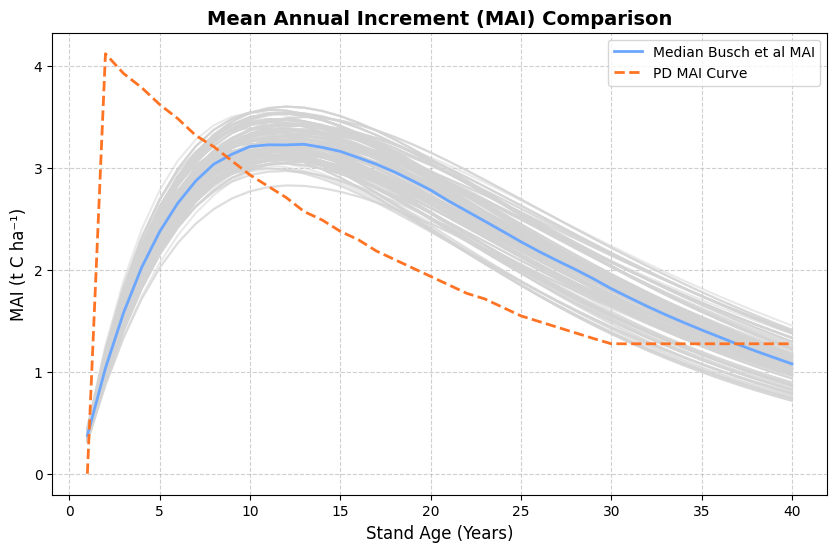

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Compute PD MAI (Mean Annual Increment) from User Data
df_user["MAI"] = df_user["AGC"].diff().fillna(0)  # First year MAI = 0

# ---- Load Raster Comparison Data ----
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)

# Extract stand ages from user data
t_values = df_user["Years"].values

# Store all Busch et al MAI curves
mai_curves = []

# Compute Busch et al MAI for each (X, Y) point
for _, row in df.iterrows():
    A = row["Raster2_BandA_Value"]
    k = row["Raster2_BandK_Value"]

    # Compute AGC using Chapman-Richards equation
    AGC = A * (1 - np.exp(-k * t_values))**2

    # Compute MAI as the difference in AGC between consecutive years
    MAI = np.diff(AGC, prepend=0)  # Prepend 0 to align sizes
    mai_curves.append(MAI)

# Convert MAI curves list to NumPy array for easy median calculation
mai_curves = np.array(mai_curves)

# Compute the median MAI trend from Busch et al.
median_mai = np.median(mai_curves, axis=0)

# ---- Create Figure ----
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all Busch et al MAI curves in light color for context
for curve in mai_curves:
    ax.plot(t_values, curve, color='lightgray', alpha=0.5)

# Plot the median Busch et al MAI trend
ax.plot(t_values, median_mai, color='#6BA6FF', linewidth=2, label="Median Busch et al MAI")

# Plot the PD-derived MAI (User Data)
ax.plot(df_user["Years"], df_user["MAI"], color='#FF7324', linewidth=2, linestyle='dashed', label="PD MAI Curve")

# Titles & Labels
ax.set_title("Mean Annual Increment (MAI) Comparison", fontsize=14, fontweight='bold')
ax.set_xlabel("Stand Age (Years)", fontsize=12)
ax.set_ylabel("MAI (t C ha⁻¹)", fontsize=12)
ax.legend(loc="upper right", frameon=True)

# Grid & Styling
ax.grid(True, linestyle="--", alpha=0.6)

# Show Plot
plt.show()


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve (19).csv


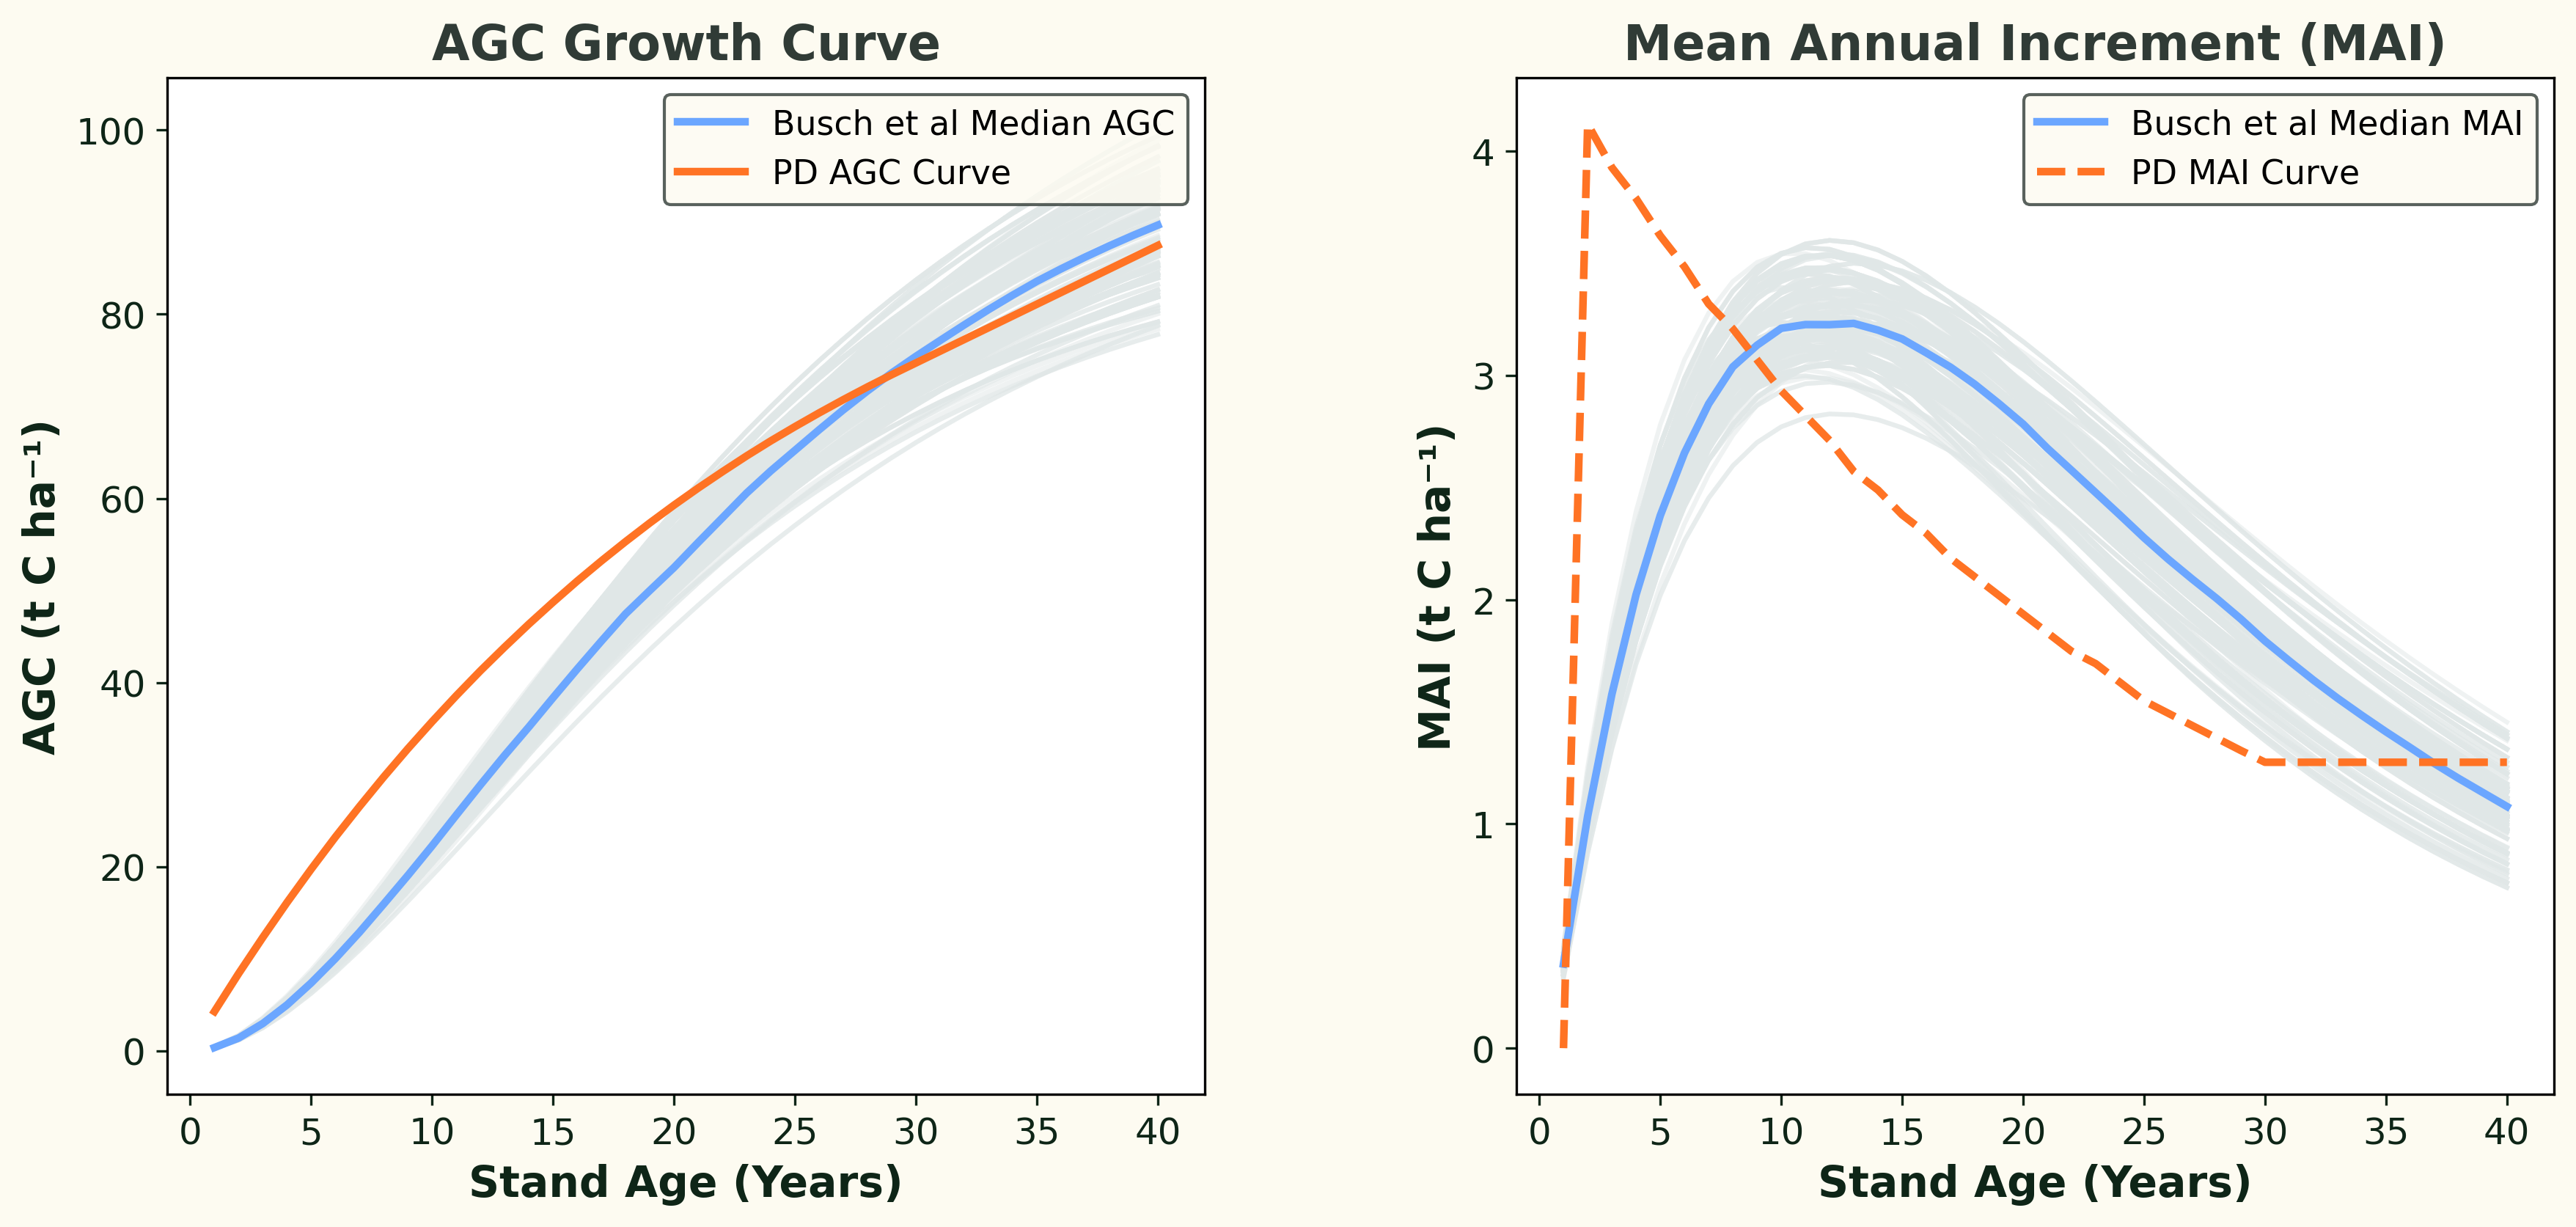

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# ---- Upload User CSV ----
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]
df_user = pd.read_csv(csv_path)

# Ensure correct column names
df_user.columns = ["Years", "AGC"]

# Compute PD MAI (Mean Annual Increment)
df_user["MAI"] = df_user["AGC"].diff().fillna(0)

# ---- Load Raster Comparison Data ----
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(csv_path)

# Extract stand ages from user data
t_values = df_user["Years"].values

# Store AGC and MAI curves from Busch et al.
agc_curves = []
mai_curves = []

# Compute Busch et al. AGC and MAI for each (X, Y) point
for _, row in df.iterrows():
    A = row["Raster2_BandA_Value"]
    k = row["Raster2_BandK_Value"]

    AGC = A * (1 - np.exp(-k * t_values))**2
    MAI = np.diff(AGC, prepend=0)

    agc_curves.append(AGC)
    mai_curves.append(MAI)

# Convert lists to NumPy arrays
agc_curves = np.array(agc_curves)
mai_curves = np.array(mai_curves)

# Compute median trends
median_agc_curve = np.median(agc_curves, axis=0)
median_mai_curve = np.median(mai_curves, axis=0)

# ---- Define Colors ----
color_pd_agc = "#FF7324"   # Blaze (PD AGC Curve)
color_lidar_green = "#81F18E"  # Walker et al AGC
color_eggshell = "#FDFBF1"  # Background
color_pine = "#0E2517"  # Axis & Text
color_charcoal = "#303B36"  # Grid lines & separators
color_flax = "#6BA6FF"  # Busch et al A Max
color_pearl = "#E0E7E7"  # Busch et al AGC Curves
color_hibiscus = "#EE88FF"  # Busch AGC End Marker

# ---- Create Figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor=color_eggshell, dpi=300)

# ---- 1️⃣ AGC Growth Curve (Left Side) ----
ax1 = axes[0]

# Plot all Busch et al. AGC curves (light gray)
for curve in agc_curves:
    ax1.plot(t_values, curve, color=color_pearl, alpha=0.5)

# Median Busch et al. AGC
ax1.plot(t_values, median_agc_curve, color=color_flax, linewidth=2.5, label="Busch et al Median AGC")

# PD AGC Curve
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=2.5, label="PD AGC Curve")

ax1.set_xlabel("Stand Age (Years)", fontsize=14, color=color_pine, fontweight="bold")
ax1.set_ylabel("AGC (t C ha⁻¹)", fontsize=14, color=color_pine, fontweight="bold")
ax1.set_title("AGC Growth Curve", fontsize=16, color=color_charcoal, fontweight="bold")
ax1.tick_params(axis="both", labelsize=12, colors=color_pine)

ax1.legend(loc="upper right", frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, fontsize=11)
ax1.grid(False)

# ---- 2️⃣ MAI Comparison (Right Side) ----
ax2 = axes[1]

# Plot all Busch et al. MAI curves (light gray)
for curve in mai_curves:
    ax2.plot(t_values, curve, color=color_pearl, alpha=0.5)

# Median Busch et al. MAI
ax2.plot(t_values, median_mai_curve, color=color_flax, linewidth=2.5, label="Busch et al Median MAI")

# PD-derived MAI
ax2.plot(df_user["Years"], df_user["MAI"], color=color_pd_agc, linewidth=2.5, linestyle='dashed', label="PD MAI Curve")

ax2.set_xlabel("Stand Age (Years)", fontsize=14, color=color_pine, fontweight="bold")
ax2.set_ylabel("MAI (t C ha⁻¹)", fontsize=14, color=color_pine, fontweight="bold")
ax2.set_title("Mean Annual Increment (MAI)", fontsize=16, color=color_charcoal, fontweight="bold")
ax2.tick_params(axis="both", labelsize=12, colors=color_pine)

ax2.legend(loc="upper right", frameon=True, facecolor=color_eggshell, edgecolor=color_charcoal, fontsize=11)
ax2.grid(False)

# ---- Adjust Layout & Save ----
plt.subplots_adjust(wspace=0.3)
plt.savefig("AGC_MAI_Infographic.png", dpi=300, bbox_inches="tight")

plt.show()
